## DS for Product Managers HW2: Clustering 
### Audrey Zhang, February 2021

### Summary of approach

A brief summary of the analytical approach used in this assignment is as follows.

1) EDA and data preparation
- Removed columns with high proportion of missing values (>3%)
- Imputed missing values for additional columns using median, after observing the distribution of these columns
   - for columns that have minimum values of 0 in the distribution where there should not be a min value of 0, these columns were also removed rather than imputing data based on potentially unreliable data
- Conducted EDA and explored the distribution of health outcomes variables 
- Created visualizations to visualize distributions of health outcome variables by state
- Explored distribution of all columns through visualizations and summary statistics
    - removed outliers that were outside of the 5 * IQR range 

2) Clustering
- Applied PCA to reduce multicollinearity and dimensions after scaling features using standardScaler 
    - Used Scree plot and cumulative explained variance plot to determine optimal # of clusters
    - Analyzed factor loadings for clusters
- Used silhouette scores and elbow method to determine optimal k for kMeans 
    - Applied kMeans clustering and analyzed outcomes, grouped by themes in variables (e.g. health, economic/financial)
- Results show meaningful clusters in based on health outcomes, median household income, lifestyle habits, socio-economic status, and demographic features 

3) Regression
- Two models, a linear regression and a random forest regression model, were used to predict rates of Premature death by county. 
    - Data were split into 70% train and 30% test datasets, with 5-fold GridSearchCV being applied to the training process to select the best hyperparameters
    - Both models performed relatively similarly on test data, achieving about 68% R2 and about 1300 RMSE. 
- The top 5 predictors of premature deaths identified were:
    - Lasso:
        - adult smoking
        - children in poverty
        - mammography screening
        - age (% above 65 and % below 18)
        - excessive drinking
    - Random Forest: 
        - children in poverty
        - adult smoking
        - median household income
        - excessive drinking
        - poor mental health days
        
4) Interpretation 
- The two models performed very similarly on test data, although Random Forest achieved slightly better performance (69% R2 and 1336 RMSE vs. 68% R2 and 1353 RMSE). Thus, the Random Forest model is slightly more accurate. 
- In Allegheny county, there is below average proportion of children in poverty and poor mental health days, and slightly above average median household income compared to other counties in the U.S.. However, the county has higher rates of adult smoking and excessive drinking, two factors that are highly important in predicting premature deaths. Public health efforts should focus on education with regard to the harms of smoking and excessive drinking, as well as other policy mechanisms to curb such unhealthy behaviors. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [2]:
data = []
with open("analytic_data2020_0.csv", "r") as file:
    next(file)
    for line in file:
        data.append(line.strip().split(','))

In [3]:
columns = data.pop(0)

In [4]:
data = pd.DataFrame(data, columns = columns)

In [5]:
data.shape

(3194, 786)

Remove columns that contain numerator, denominator, confidence intervals, and other features associated with specific variables. 

In [6]:
remove = data.columns[data.columns.str.contains(pat = 'numerator|denominator|cilow|cihigh|flag')]

data = data[[i for i in data.columns if i not in remove]]

In [7]:
data.dtypes

statecode        object
countycode       object
fipscode         object
state            object
county           object
                  ...  
v027_rawvalue    object
v031_rawvalue    object
v032_rawvalue    object
v035_rawvalue    object
v097_rawvalue    object
Length: 229, dtype: object

As shown above, the data have been read in as type object. Cast columns that start with 'v' as numeric

In [8]:
numeric = list(data.columns[data.columns.str.contains(pat = '^v')])
data[numeric] = data[numeric].apply(pd.to_numeric)

Next, assign column names based on the 2020 data dictionary available here: 
https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2020_1.xlsx 

In [9]:
col_df = pd.read_excel("DataDictionary_2020_1.xlsx")

In [10]:
# only keep observations starting with 'rawvalue' in name, since these are columns that need to be mpaped
col_df = col_df[col_df['Variable Name'].str.contains('^v')].copy()

In [11]:
col_df

Variable Name                            Measure  \
7       v001_rawvalue          Premature death raw value   
8      v001_numerator          Premature death numerator   
9    v001_denominator        Premature death denominator   
10         v001_cilow             Premature death CI low   
11        v001_cihigh            Premature death CI high   
..                ...                                ...   
781     v027_rawvalue  Female population 18-44 raw value   
782     v031_rawvalue  Female population 45-64 raw value   
783     v032_rawvalue    Female population 65+ raw value   
784     v035_rawvalue  Total female population raw value   
785     v097_rawvalue        Population growth raw value   

                                           Description  
7    Years of potential life lost before age 75 per...  
8                                                       
9                                                       
10                                                      
11                                                      
..                                                 ...  
781                      Number of females ages 18-44.  
782                      Number of females ages 45-64.  
783               Number of females ages 65 and older.  
784                           Total number of females.  
785  Percentage change in population since the last...  

[779 rows x 3 columns]

In [12]:
# text cleaning to shorten some measure descriptions
col_df['Measure']= col_df['Measure'].str.replace('population', 'pop', case=False)
col_df['Measure']= col_df['Measure'].str.replace('raw value', '', case=False)
col_df['Measure']= col_df['Measure'].str.replace('coronary heart disease', 'CHD', case=False)
col_df['Measure']= col_df['Measure'].str.replace('median', 'med', case=False)
col_df['Measure']= col_df['Measure'].str.replace('children eligible for free or reduced price lunch', 'child elig red/free lunch', case=False)
col_df['Measure']= col_df['Measure'].str.replace('motor vehicle', 'vehicle', case=False)
col_df['Measure']= col_df['Measure'].str.replace('overdose', 'od', case=False)
col_df['Measure']= col_df['Measure'].str.replace('diabetes', 'DB', case=False)
col_df['Measure']= col_df['Measure'].str.replace('driving alone to work', 'drive alone', case=False)
col_df['Measure']= col_df['Measure'].str.replace('percentage of', 'pct', case=False)
col_df['Measure']= col_df['Measure'].str.replace('households', 'HHs', case=False)
col_df['Measure']= col_df['Measure'].str.replace('sexually transmitted infections', 'STIs', case=False)
col_df['Measure']= col_df['Measure'].str.replace('\n', ' ', case=False)
col_df['Measure']= col_df['Measure'].str.replace('Number of juvenile delinquency cases formally processed by a juvenile court', '# juv delinquency cases processed', case=False)
col_df['Measure']= col_df['Measure'].str.replace('Number of informally handled juvenile delinquency cases', '# juv delinquency cases informally handled', case=False)
col_df['Measure']= col_df['Measure'].str.replace('Ratio of pop to primary care providers other than physicians.', 'pop to PCP ratio (not physicians)', case=False)
col_df['Measure']= col_df['Measure'].str.replace('raw value', '', case=False)

In [13]:
col_dict = pd.Series(col_df['Measure'].str.strip().values,index=col_df['Variable Name']).to_dict()

In [14]:
data.rename(columns = col_dict, inplace = True)

In [15]:
data.columns

Index(['statecode', 'countycode', 'fipscode', 'state', 'county', 'year',
       'county_ranked', 'Premature death', 'Premature death (AIAN)',
       'Premature death (Asian/Pacific Islander)',
       ...
       'Male pop 18-44', 'Male pop 45-64', 'Male pop 65+', 'Total male pop',
       'Female pop 0-17', 'Female pop 18-44', 'Female pop 45-64',
       'Female pop 65+', 'Total female pop', 'pop growth'],
      dtype='object', length=229)

In [16]:
data.shape

(3194, 229)

Before processing the data (remove missing values, etc), it is important to first decide on the level of observation. This dataset contains rows at the country (US), as well as state and county levels. To maintain a more granular level of data, county-level observations will be used for this analysis. Thus, the state and country rows need to be removed.

To do so, the 'fipscode' column will be used. In general, the numbering scheme for county codes end with 000 for a given state, and start from 001 for specific counties. Thus, filtering out all observations with fipscodes ending in 000 would result in the relevant observations associated with counties.

In [17]:
counties = data[data['fipscode'].str.contains('000$')==False].copy()

In [18]:
counties.shape

(3142, 229)

In [19]:
counties.head()

statecode countycode fipscode state          county  year county_ranked  \
2        01        001    01001    AL  Autauga County  2020             1   
3        01        003    01003    AL  Baldwin County  2020             1   
4        01        005    01005    AL  Barbour County  2020             1   
5        01        007    01007    AL     Bibb County  2020             1   
6        01        009    01009    AL   Blount County  2020             1   

   Premature death  Premature death (AIAN)  \
2      8128.591190                     NaN   
3      7354.122530                     NaN   
4     10253.573403                     NaN   
5     11977.539484                     NaN   
6     11335.071134                     NaN   

   Premature death (Asian/Pacific Islander)  ...  Male pop 18-44  \
2                                       NaN  ...             NaN   
3                                       NaN  ...             NaN   
4                                       NaN  ...             NaN   
5                                       NaN  ...             NaN   
6                                       NaN  ...             NaN   

   Male pop 45-64  Male pop 65+  Total male pop  Female pop 0-17  \
2             NaN           NaN             NaN              NaN   
3             NaN           NaN             NaN              NaN   
4             NaN           NaN             NaN              NaN   
5             NaN           NaN             NaN              NaN   
6             NaN           NaN             NaN              NaN   

   Female pop 18-44  Female pop 45-64  Female pop 65+  Total female pop  \
2               NaN               NaN             NaN               NaN   
3               NaN               NaN             NaN               NaN   
4               NaN               NaN             NaN               NaN   
5               NaN               NaN             NaN               NaN   
6               NaN               NaN             NaN               NaN   

   pop growth  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  

[5 rows x 229 columns]

### Missing values

Check out the amount of missing values

In [20]:
pd.set_option('display.max_rows', 500)
counties.isnull().sum().sort_values(ascending=False)

Math scores (AIAN)                                           3142
Reading scores (AIAN)                                        3142
Infant mortality (AIAN)                                      3123
Homicides (AIAN)                                             3108
Drug od deaths (Asian/Pacific Islander)                      3104
Firearm fatalities (AIAN)                                    3101
Drug od deaths (AIAN)                                        3098
Homicides (Asian/Pacific Islander)                           3095
Child mortality (AIAN)                                       3089
Firearm fatalities (Asian/Pacific Islander)                  3083
Alcohol-related hospitalizations                             3078
Infant mortality (Asian/Pacific Islander)                    3076
Fall fatalities 65+                                          3076
Cerebrovascular disease hospitalizations                     3074
Suicides (AIAN)                                              3073
W-2 enroll

There are 3142 rows in the counties dataset, and quite a few columns have more than 100 missing values. These variables will be removed first from the dataset.

In [21]:
na_counts = counties.isnull().sum()

In [22]:
counties = counties[[c for c in counties.columns if c not in na_counts[na_counts>=100].index]]

Some values, like Teen Births (White), are subsets of a broader metric (e.g. Teen Births). These variables will be removed, as some part of the information provided is captured in the more aggregate metric. All metrics with () will be dropped.

In [23]:
counties.drop(columns = [col for col in counties.columns if '(' in col], axis=1, inplace=True)

similarly, the ratio variables are also already capatured by other metrics (e.g. 'ratio of pop to primary care physicians' contains similar information to the number of primary care physicians variable). These variables can also be dropped.

In [24]:
counties.drop(columns = [col for col in counties.columns if 'ratio' in col.lower()], axis=1, inplace=True)

Before dropping any more columns, first take a look at the row-wise count of missing values per row. Given ~3000 counties, if only a few rows have a high number of missing values, we can remove those rows without dramatically changing the distribution of our data.

In [25]:
counties.shape

(3142, 65)

In [26]:
counties.isnull().sum(axis=1)[counties.isnull().sum(axis=1)>6].count()

10

There are 10 total observations with 6 or more variables missing. This accounts for about 10% of the current ~60 variables, so these rows will be dropped from the dataset.

In [27]:
counties = counties[counties.isnull().sum(axis=1)<6]

This analysis is concerned with the rate of premature death as an indication of health outcome, and seeks to examine factors that can predict premature death. As premature death is an outcome variable, it will not be imputed to avoid biasing the data and model. The ~50 rows with missing values in this column acount for only 1.6% of the observations, so they will also be removed from the analysis.

In [28]:
counties = counties[counties['Premature death'].isnull()==False]

The remaining variables with missing values will be imputed. To do so, first check out the distribution of these variables.

In [29]:
counties.isnull().sum().sort_values(ascending=False)

Dentists                                               87
High school graduation                                 69
Drinking water violations                              41
Air pollution - particulate matter                     24
Other primary care providers                           21
Life expectancy                                        21
Food environment index                                 19
Limited access to healthy foods                        19
Alcohol-impaired driving deaths                        18
Preventable hospital stays                             11
Flu vaccinations                                        7
Mammography screening                                   7
% Rural                                                 2
Premature age-adjusted mortality                        2
Income inequality                                       2
drive alone                                             1
Long commute - driving alone                            1
Access to exer

##### Imputation

Remaining missing values will be imputed.

Unless the distribution is normal, the median is a better measure of center compared to the mean, which is more easily influenced by outliers. First, plot the distribution of columns with missing values. As shown below, almost all are skewed, so the median will be used for imputation.

Additionally, some distributions do not follow a normal curve. % Rural, for example, has a bimodal distribution. Food Environment Index and Mammography screening (among others), have distinctive spikes throughout the distribution. As health/quality of life metrics are often dependent on region, the median (or mode for categorical/binary variables) within each state will be used for imputation for all variables.

In [30]:
missing = counties.isnull().sum()
missing_list = missing[missing>0].index

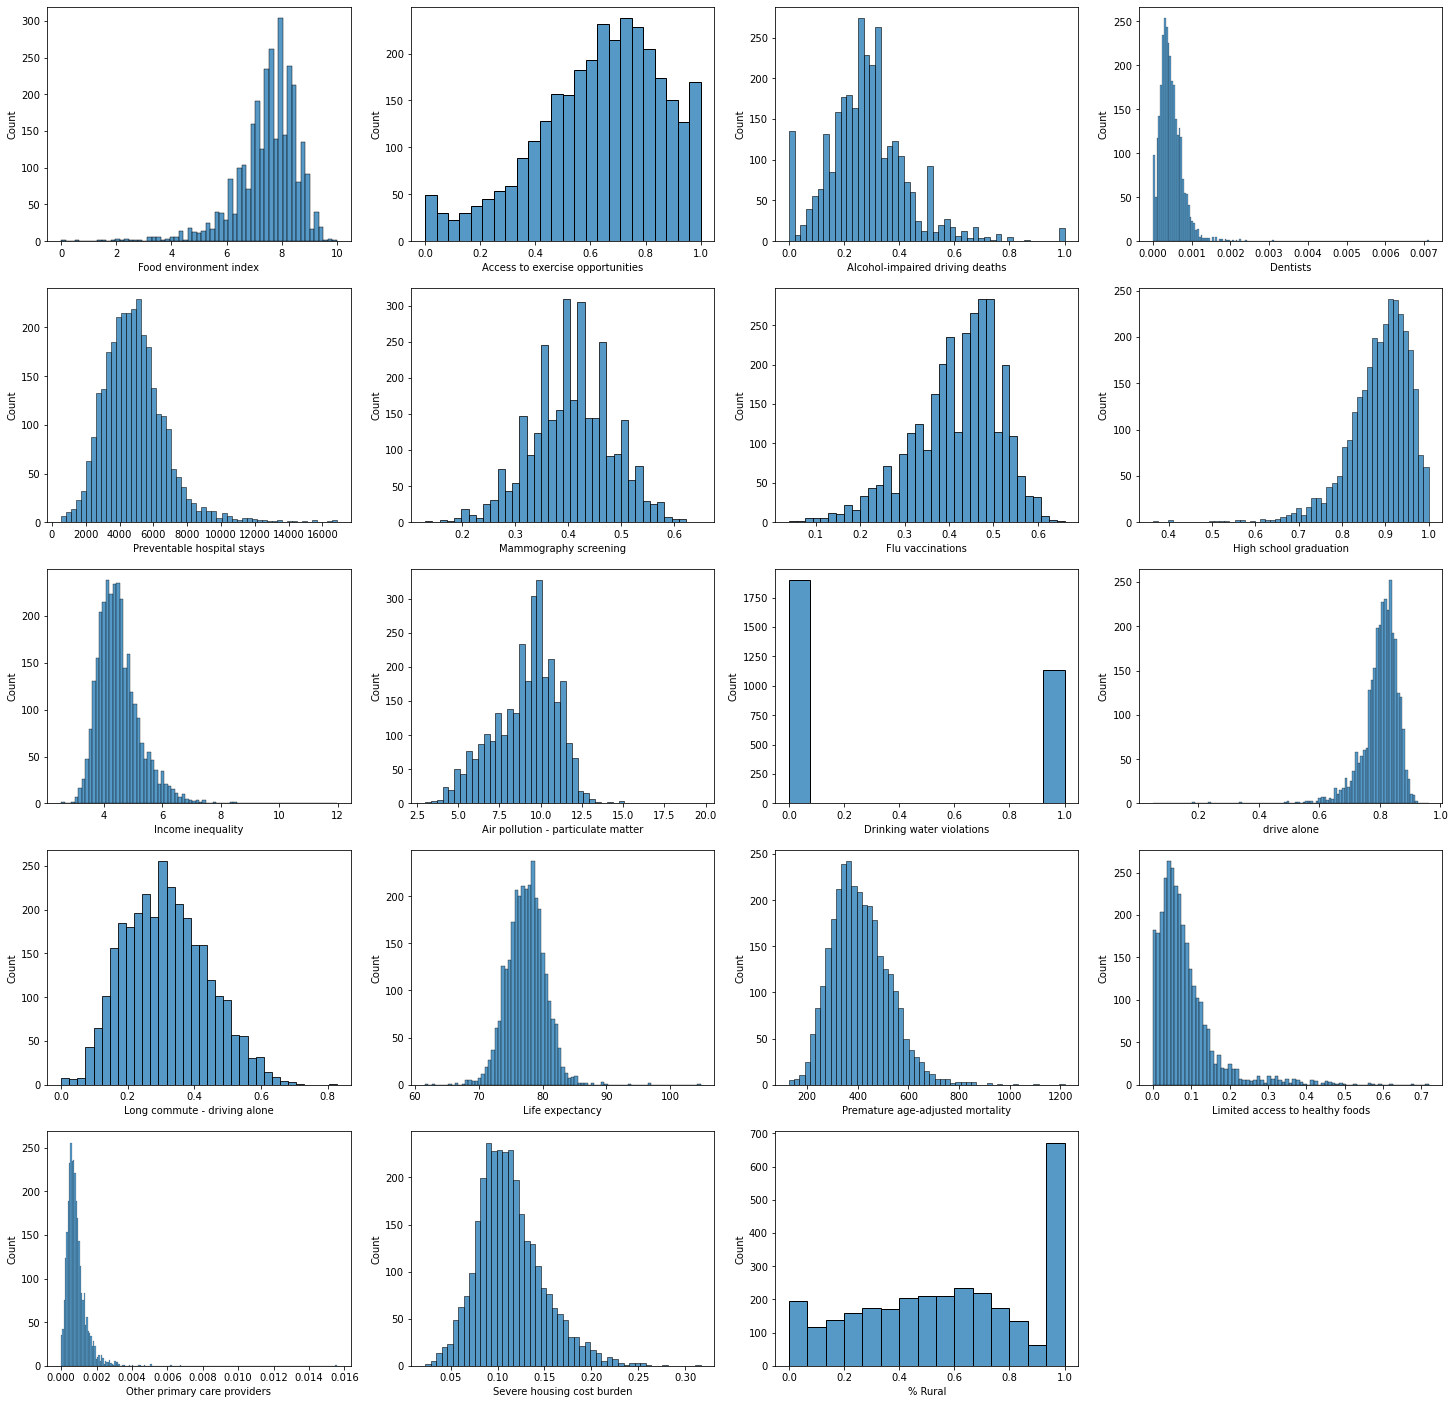

In [31]:
f = plt.figure(figsize=(25, 25))
f.tight_layout()
for i, column in enumerate(missing_list, 1):
    plt.subplot(5,4,i)
    sns.histplot(counties[column])

In [32]:
f.clear()
plt.close(f)

In [33]:
counties[missing_list].describe().transpose()

count         mean          std  \
Food environment index              3059.0     7.482053     1.116097   
Access to exercise opportunities    3077.0     0.633099     0.228050   
Alcohol-impaired driving deaths     3060.0     0.282650     0.145403   
Dentists                            2991.0     0.000464     0.000310   
Preventable hospital stays          3067.0  4873.394848  1835.864676   
Mammography screening               3071.0     0.406695     0.076317   
Flu vaccinations                    3071.0     0.418746     0.096976   
High school graduation              3009.0     0.886868     0.070064   
Income inequality                   3076.0     4.521994     0.755482   
Air pollution - particulate matter  3054.0     9.079371     1.926586   
Drinking water violations           3037.0     0.375041     0.484213   
drive alone                         3077.0     0.800030     0.070140   
Long commute - driving alone        3077.0     0.315234     0.124130   
Life expectancy                     3057.0    77.437646     2.993204   
Premature age-adjusted mortality    3076.0   408.609832   114.055022   
Limited access to healthy foods     3059.0     0.082344     0.076330   
Other primary care providers        3057.0     0.000852     0.000614   
Severe housing cost burden          3077.0     0.113173     0.035616   
% Rural                             3076.0     0.578201     0.312426   

                                           min          25%          50%  \
Food environment index                0.000000     7.000000     7.700000   
Access to exercise opportunities      0.000000     0.489848     0.661811   
Alcohol-impaired driving deaths       0.000000     0.200000     0.275236   
Dentists                              0.000000     0.000270     0.000419   
Preventable hospital stays          536.000000  3641.500000  4729.000000   
Mammography screening                 0.130000     0.360000     0.410000   
Flu vaccinations                      0.040000     0.360000     0.430000   
High school graduation                0.363014     0.850144     0.898734   
Income inequality                     2.543129     4.015325     4.403489   
Air pollution - particulate matter    3.000000     7.800000     9.400000   
Drinking water violations             0.000000     0.000000     0.000000   
drive alone                           0.049068     0.776860     0.812040   
Long commute - driving alone          0.000000     0.221000     0.309000   
Life expectancy                      61.625629    75.534838    77.464683   
Premature age-adjusted mortality    127.765835   327.823159   396.252045   
Limited access to healthy foods       0.000000     0.035749     0.064362   
Other primary care providers          0.000000     0.000502     0.000732   
Severe housing cost burden            0.022585     0.089152     0.108569   
% Rural                               0.000000     0.327488     0.586789   

                                            75%           max  
Food environment index                 8.200000     10.000000  
Access to exercise opportunities       0.801887      1.000000  
Alcohol-impaired driving deaths        0.352941      1.000000  
Dentists                               0.000613      0.007113  
Preventable hospital stays          5815.000000  16851.000000  
Mammography screening                  0.460000      0.650000  
Flu vaccinations                       0.490000      0.660000  
High school graduation                 0.936709      1.000000  
Income inequality                      4.874263     11.970639  
Air pollution - particulate matter    10.400000     19.700000  
Drinking water violations              1.000000      1.000000  
drive alone                            0.840417      0.960759  
Long commute - driving alone           0.401000      0.827000  
Life expectancy                       79.338623    104.740145  
Premature age-adjusted mortality     477.783303   1216.800064  
Limited access to healthy foods        0.104059    

The summary statistics further support the finding that most variables are somewhat skewed. Preventable hospital stays, for example, has a mean of 4873 and std 1836, but the maximum value is 16,840. 

Notably, several variables have a minimum of 0: food environment index, access to exercise opportunities, alcohol-impaired driving deaths, long-commute - driving alone, and limited access to healthy foods. These metrics should not have a minimum value of 0 based on my understanding of the realities of life, and these 0 values represent outliers in the data. It is likely that these statistics are misreported and thus unreliable. To impute based on incorrect data would introduce noise and error into the dataset. These features will be dropped from analysis rather than kept in with missing values imputed. Other metrics like Dentists, % Rural, and Other primary care providers also have a minimum value of 0, but it is certainly plausible (although unlikely) that certain counties do not have dentists/other PCPs within the county, and very plausible that metropolitan counties would have 0% Rural areas. 

In [34]:
drop = ['Food environment index', 'Access to exercise opportunities', 'Alcohol-impaired driving deaths', 'Long commute - driving alone', 'Limited access to healthy foods']
counties.drop(columns = drop, inplace=True)

In [35]:
# re-create the list of missing variables 
missing = counties.isnull().sum()
missing_list = missing[missing>0].index

for col in missing_list:
    print(col)
    counties[col] = counties[['state', col]].groupby("state").transform(lambda x: x.fillna(x.median()))

Dentists
Preventable hospital stays
Mammography screening
Flu vaccinations
High school graduation
Income inequality
Air pollution - particulate matter
Drinking water violations
drive alone
Life expectancy
Premature age-adjusted mortality
Other primary care providers
Severe housing cost burden
% Rural


In [36]:
counties.isnull().sum()

statecode                                               0
countycode                                              0
fipscode                                                0
state                                                   0
county                                                  0
year                                                    0
county_ranked                                           0
Premature death                                         0
Poor or fair health                                     0
Poor physical health days                               0
Poor mental health days                                 0
Adult smoking                                           0
Adult obesity                                           0
Physical inactivity                                     0
Excessive drinking                                      0
Uninsured                                               0
Dentists                                                0
Preventable ho

It looks like air pollution and drinking water violations still have missing values. This is likely because the states that these observations belong to did not report any information for these attributes. 

In [37]:
counties[counties['Air pollution - particulate matter'].isnull()]['state'].unique()

array(['AK', 'HI'], dtype=object)

In [38]:
counties[counties['Drinking water violations'].isnull()]['state'].unique()

array(['HI'], dtype=object)

As these missing values are systematic (i.e. non-random), it would affect the distribution of the data to drop these rows entirely. Thus, these columns will be dropped instead.

In [39]:
counties = counties.drop(columns = ['Air pollution - particulate matter', 'Drinking water violations'])

##### Additional feature selection

Lastly, variables statecode, countycode, fipscode, year, and county_ranked will be dropped as they are not relevant to this analysis.

In [40]:
counties.drop(columns = ['statecode', 'countycode', 'fipscode', 'year', 'county_ranked'], inplace = True)

The remaining dataset has 3078 rows and 58 variables.

In [41]:
counties.shape

(3078, 53)

### Exploratory data analysis

In [42]:
counties.describe().transpose()

count           mean  \
Premature death                                     3078.0    8530.197158   
Poor or fair health                                 3078.0       0.179982   
Poor physical health days                           3078.0       4.001931   
Poor mental health days                             3078.0       4.180071   
Adult smoking                                       3078.0       0.175195   
Adult obesity                                       3078.0       0.329278   
Physical inactivity                                 3078.0       0.274091   
Excessive drinking                                  3078.0       0.174901   
Uninsured                                           3078.0       0.113990   
Dentists                                            3078.0       0.000462   
Preventable hospital stays                          3078.0    4868.103476   
Mammography screening                               3078.0       0.406559   
Flu vaccinations                                    3078.0       0.418561   
High school graduation                              3078.0       0.886284   
Some college                                        3078.0       0.577201   
Unemployment                                        3078.0       0.041396   
Children in poverty                                 3078.0       0.211669   
Income inequality                                   3078.0       4.522110   
Children in single-parent HHs                       3078.0       0.325493   
Social associations                                 3078.0      11.796383   
Severe housing problems                             3078.0       0.139042   
pct HHs with high housing costs                     3078.0       0.111127   
pct HHs with overcrowding                           3078.0       0.024258   
pct HHs with lack of kitchen or plumbing facili...  3078.0       0.011983   
drive alone                                         3078.0       0.800027   
Life expectancy                                     3078.0      77.439601   
Premature age-adjusted mortality                    3078.0     408.602330   
Frequent physical distress                          3078.0       0.121670   
Frequent mental distress                            3078.0       0.130318   
DB prevalence                                       3078.0       0.121736   
Food insecurity                                     3078.0       0.132836   
Insufficient sleep                                  3078.0       0.331343   
Uninsured adults                                    3078.0       0.135353   
Uninsured children                                  3078.0       0.061305   
Other primary care providers                        3078.0       0.000851   
med household income                                3078.0   52749.031514   
Traffic volume                                      3078.0     131.075721   
Homeownership                                       3078.0       0.714650   
Severe housing cost burden                          3078.0       0.113178   
pop                                                 3078.0  106261.624756   
% below 18 years of age                             3078.0       0.220987   
% 65 and older                                      3078.0       0.191842   
% Non-Hispanic Black                                3078.0       0.091576   
% American Indian & Alaska Native                   3078.0       0.022876   
% Asian                                             3078.0       0.015664   
% Native Hawaiian/Other Pacific Islander            3078.0       0.001260   
% Hispanic                                          3078.0       0.096377   
% Non-Hispanic White                                3078.0       0.759489   
% not proficient in English                         3078.0       0.016966   
% Females                                           3078.0       0.499200   
% Rural                                             3078.0       0.578365   

                                                

The summary stats above suggest that the features vary greatly in terms of overall variance and range. It is critical to standardize the data before modelling. 

The summary stats also indicate a minimum value of 0 in Traffic Volume as a feature, as well as Children in Single-parent HHs and social associations. These values are clear outliers and should be removed. Prior to doing so, first visually examine the distribution of features.

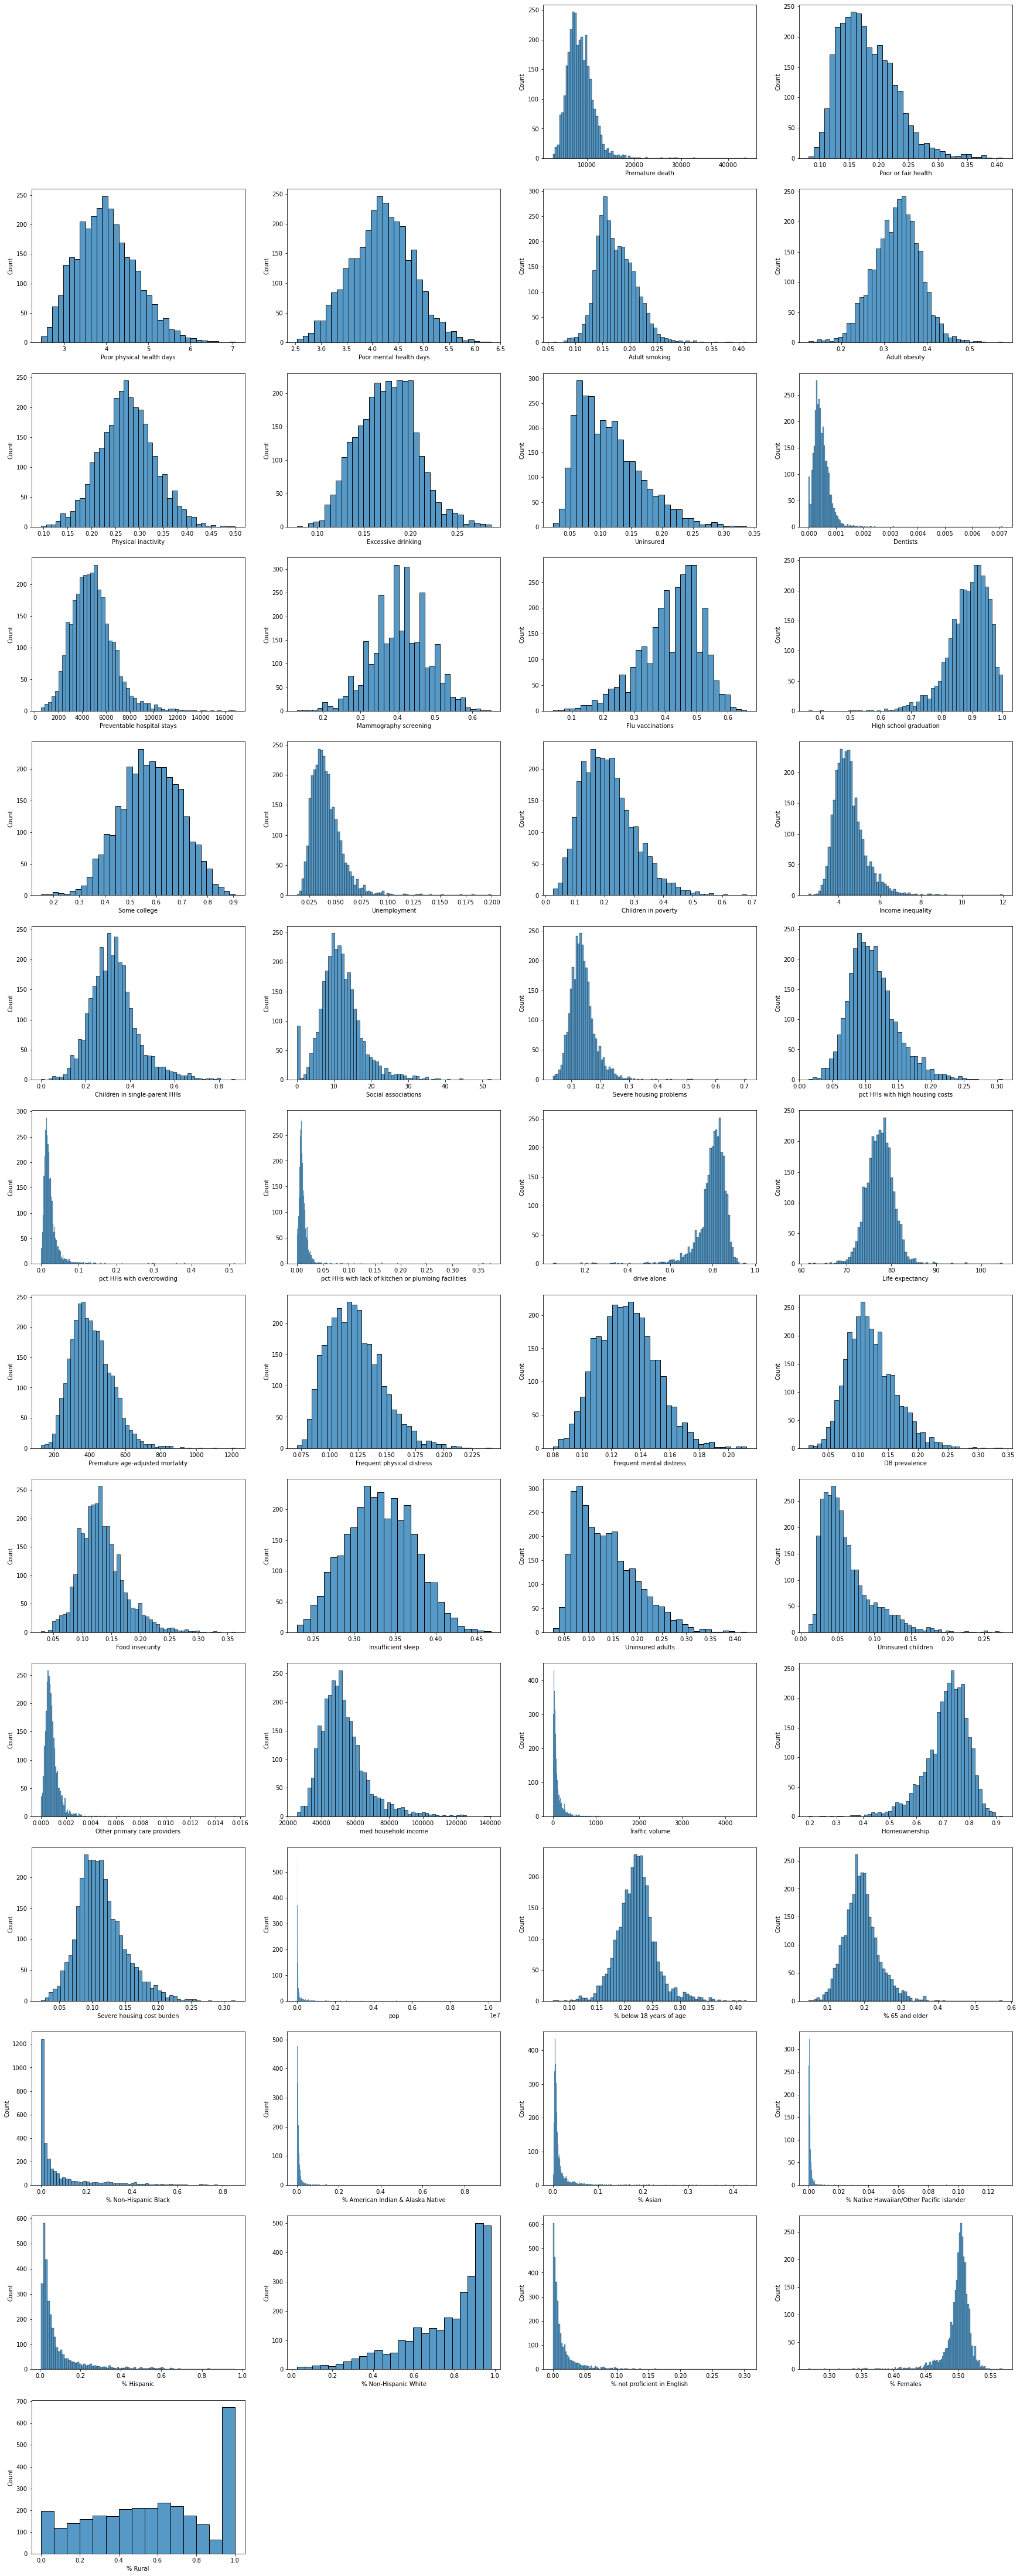

In [43]:
f = plt.figure(figsize=(30, 80))
f.tight_layout()
from pandas.api.types import is_numeric_dtype

for i, column in enumerate(counties.columns, 1):
    if is_numeric_dtype(counties[column]):
        plt.subplot(14,4,i)
        sns.histplot(counties[column])

In [44]:
f.clear()
plt.close(f)

From the above plot, it appears that most features are rather normally distributed with some skew. Skewness is more extreme in some variables, such as Unemployment, Income Inequality, and % Non-hispanic White, compared to other attributes. 

The race distribution related metrics (% Asian, % Native Hawaiian/Other Pacific Islander, etc.) generally have small variance with skew, although variance is impacted by the unit and could be improved by scaling the features. 

Next, the boxplots below visualize the center and std, as well as outliers of each variable. As shown, the distribution for all varibles are quite varied with significant outliers in some cases.

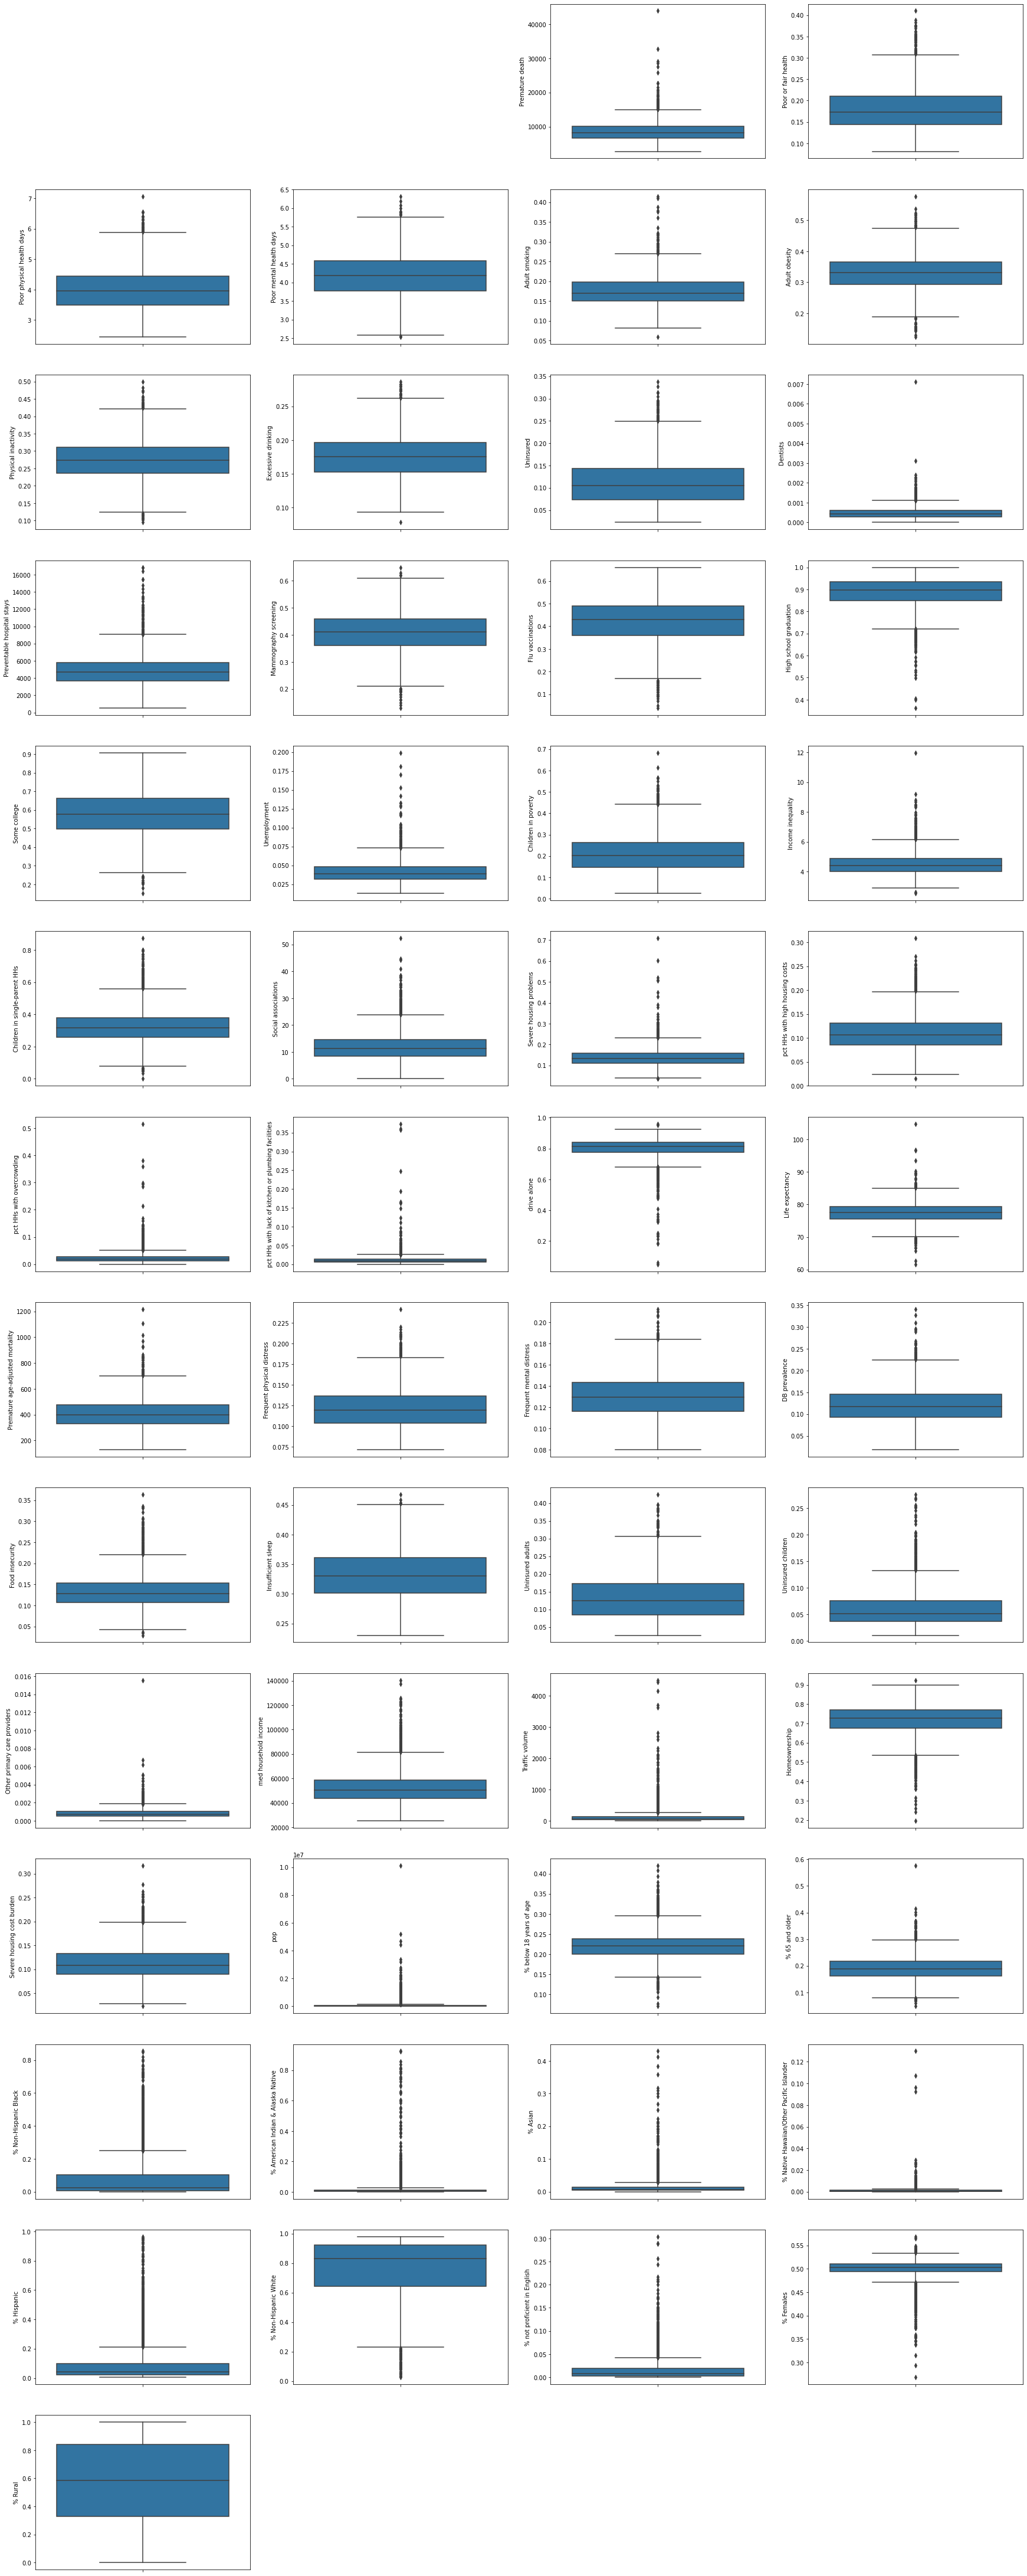

In [45]:
f = plt.figure(figsize=(30, 80))
f.tight_layout()

for i, column in enumerate(counties.columns, 1):
    if is_numeric_dtype(counties[column]):
        plt.subplot(14,4,i)
        sns.boxplot(y = column, data = counties)

In [46]:
f.clear()
plt.close(f)

Before removing outliers, the final step would be to take a look at the distributions of the health outcomes of interest.

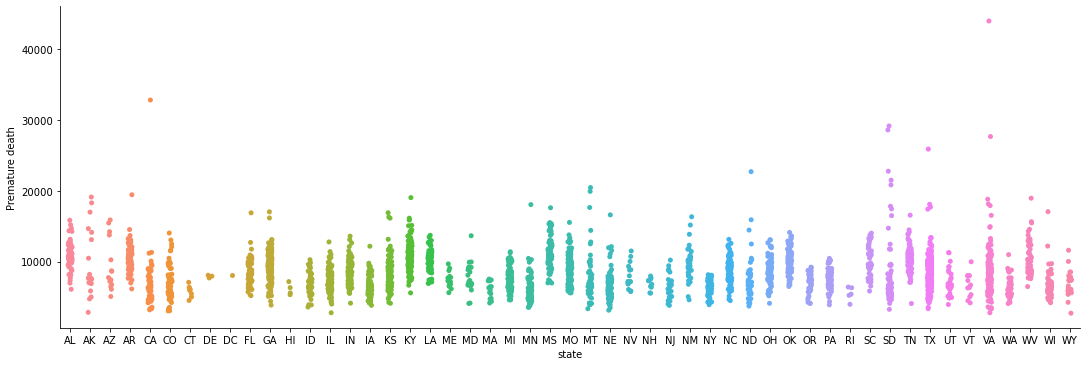

In [47]:
sns.catplot(x = 'state', y = 'Premature death', data = counties, height = 5, aspect = 3)

There definitely appear to be outliers in CA, ND, and VA for the premature death variable, as indicated by extreme observations very far apart from other points in the state.

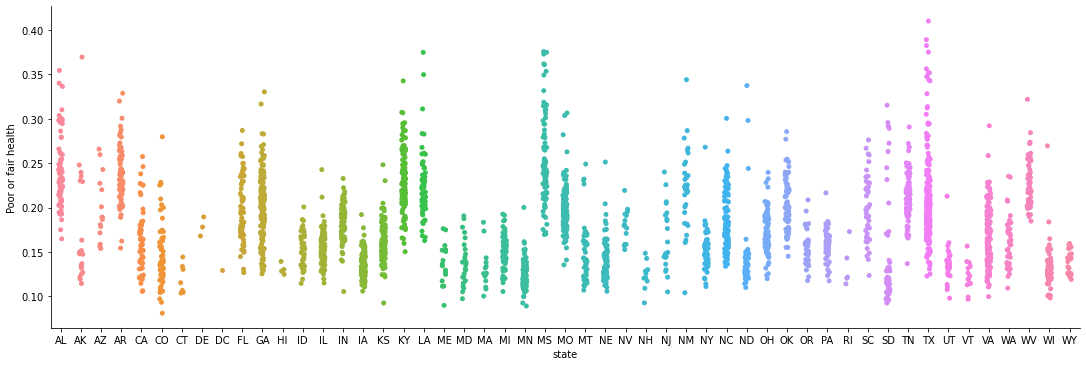

In [48]:
sns.catplot(x = 'state', y = 'Poor or fair health', data = counties, height = 5, aspect = 3)

For this variable, AK and NY, and perhaps UT, WI, and NM appear to have clear outliers. 

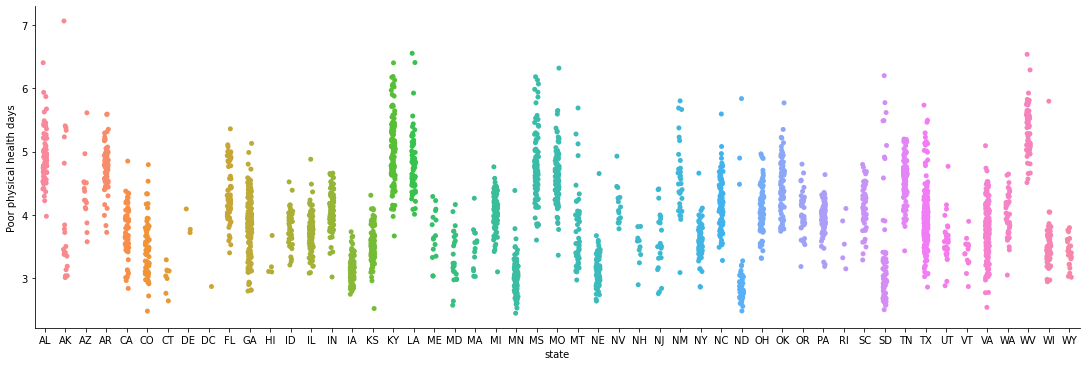

In [49]:
sns.catplot(x = 'state', y = 'Poor physical health days', data = counties, height = 5, aspect = 3)

Here, AK, NE, and WI have clear outliers. AZ and ND have very skewed distributions, and SD has a very spread out distribution. 

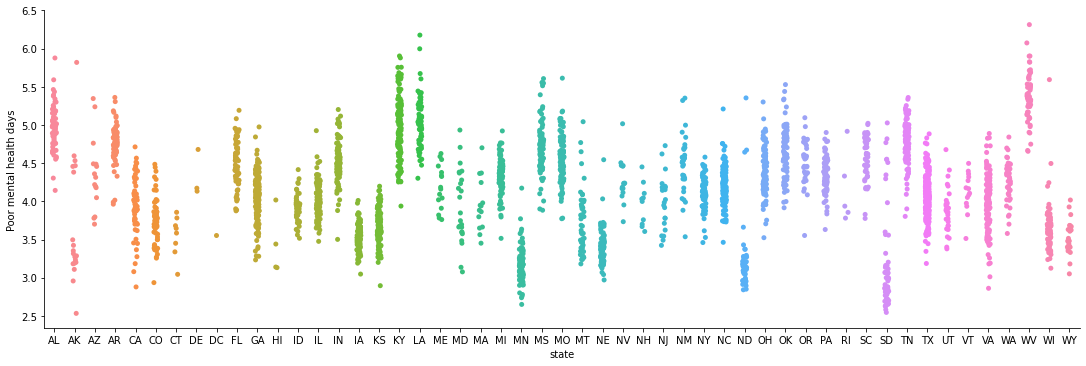

In [50]:
sns.catplot(x = 'state', y = 'Poor mental health days', data = counties, height = 5, aspect = 3)

Again, AK here seems to have several outliers, along with WI. ND and SD have very skewed distributions. 

Based on the collective analysis of all 4 health outcome variables, patterns emerge in the states that show skewed distributions (e.g. ND) and those that seem to have outliers (e.g. AI, WI). Since these patterns exist across variables, these outliers are likely due to actual variation in the data rather than incorrect data entry. Since these variables are direct indicators reflecting health outcomes, outliers will not be removed to avoid losing important information in factors that be the driving factor behind variability in these indicators. 

To further examine potential outliers, the IQR method will be used to determine potential outliers. Since there will naturally be a lot of variation between states/regions for most of these feaures, a more relaxed constraint of 5 * IQR will be used to flag potential outliers.

In [51]:
for col in counties.columns:
    if is_numeric_dtype(counties[col]):
        Q1 =counties[col].quantile(0.25)
        Q3 = counties[col].quantile(0.75)
        IQR = Q3 - Q1
        print('{:50s}\tIQR: {:.3f}'.format(col, IQR), end = '\t')
        n_outliers = counties[(counties[col]> Q3 + 5 * IQR) | (counties[col]< Q1 - 5 * IQR)]['county'].count()
        print('number of outliers: {:d}'.format(n_outliers))

Premature death                                   	IQR: 3333.141	number of outliers: 5
Poor or fair health                               	IQR: 0.066	number of outliers: 0
Poor physical health days                         	IQR: 0.964	number of outliers: 0
Poor mental health days                           	IQR: 0.810	number of outliers: 0
Adult smoking                                     	IQR: 0.048	number of outliers: 0
Adult obesity                                     	IQR: 0.072	number of outliers: 0
Physical inactivity                               	IQR: 0.075	number of outliers: 0
Excessive drinking                                	IQR: 0.044	number of outliers: 0
Uninsured                                         	IQR: 0.071	number of outliers: 0
Dentists                                          	IQR: 0.000	number of outliers: 4
Preventable hospital stays                        	IQR: 2172.250	number of outliers: 2
Mammography screening                             	IQR: 0.100	number o

It is clear that the race-related percentage features (e.g. % Non-Hispanic White) have a high proportion of outliers. This is to be expected, as there are select regions in the U.S. that have much higher concentrations of certain minority groups than other regions. These outliers are not due to data collection issues and do not need to be corrected. However, they do introduce a lot of noise into the dataset, and since this project is looking to determine predictors of poor health outcomes for policy action, examining the demographic makeup of the counties (although interesting) would not provide any direct indication of immediate and actional policy recommendations to improve health outcomes. These variables will be removed from the dataset.

For other variables, the IQR would be used to remove outliers. Since the U.S. is quite diverse and high variability on these metrics is rather expected, a very relaxed threshold of 5 * IQR would be used to remove the outlier observations. 

In [52]:
counties.drop(columns = ['% Non-Hispanic Black', '% American Indian & Alaska Native', '% Asian', '% Native Hawaiian/Other Pacific Islander', '% Hispanic', '% Non-Hispanic White'], inplace = True)

Next, outliers will be removed from the analysis. As mentioned previously, outliers in the health outcomes variables will not be removed to avoid loss of information.

In [53]:
health_vars = ['Premature death', 'Poor or fair health', 'Poor physical health days', 'Poor mental health days']

for col in counties.columns:
    if is_numeric_dtype(counties[col]) and i not in health_vars:
        Q1 =counties[col].quantile(0.25)
        Q3 = counties[col].quantile(0.75)
        IQR = Q3 - Q1
        counties = counties[(counties[col]< Q3 + 5 * IQR) & (counties[col]> Q1 - 5 * IQR)]

In [54]:
counties.shape

(2649, 47)

A total of about 350 rows were removed.

There are quite a lot of features still. To examine whether features overlap (are linearly correlated with eachother and thus provide redundant information), examine the correlation plot between features.

<AxesSubplot:>

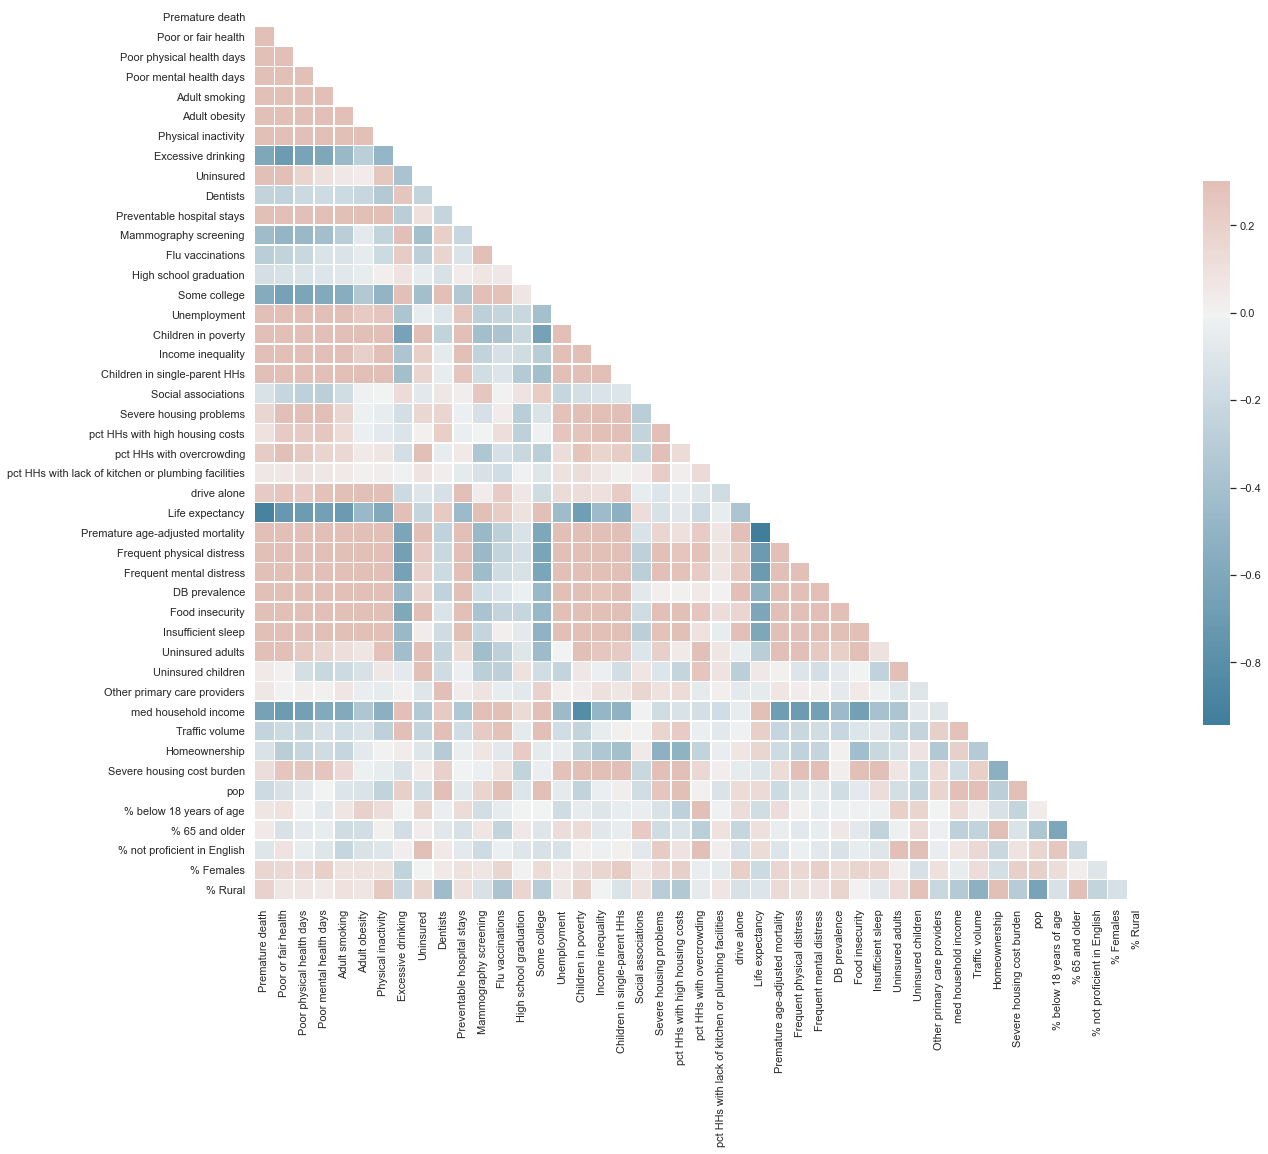

In [55]:
sns.set_theme(style="white")

corr = counties.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There is quite a bit of multicollinearity between features. Median household income, for instance, correlate highly with the health outcome variables, as well as children in poverty, premature age-adjusted mortality, frequent physical distress, DB prevalence, food insecurity, and others. The following table lists the absolute correlation coefficients that are above 0.8, indicating strong correlation. 

In [56]:
corr = counties.corr().abs() 

redundant = set()
cols = [i for i in counties.columns if i not in ['state', 'county']]
for i in range(0, counties.shape[1]-2):
    for j in range(0, i+1): 
        redundant.add((cols[i], cols[j]))

corr = corr.unstack().abs() 
corr.drop(labels = redundant)
so_corr = corr.sort_values(kind="quicksort", ascending=False)
so_corr[(so_corr!=1) & (so_corr >= 0.8)].drop_duplicates()

Uninsured                         Uninsured adults                    0.989923
Frequent physical distress        Poor physical health days           0.987427
Poor mental health days           Frequent mental distress            0.974268
Poor physical health days         Frequent mental distress            0.967956
Frequent mental distress          Frequent physical distress          0.966821
Premature age-adjusted mortality  Premature death                     0.949775
Poor mental health days           Poor physical health days           0.944884
Life expectancy                   Premature age-adjusted mortality    0.942895
Poor or fair health               Frequent physical distress          0.931819
Severe housing problems           pct HHs with high housing costs     0.922641
Frequent physical distress        Poor mental health days             0.917245
Poor or fair health               Poor physical health days           0.902808
Premature death                   Life expectancy   

As we can see, there are quite a few pairs of variables that are highly linearly correlated. As such, PCA will first be applied to remove multicollinearity prior to additional modelling.

Lastly, it is important to understand how different health outcome variables vary with each other. 

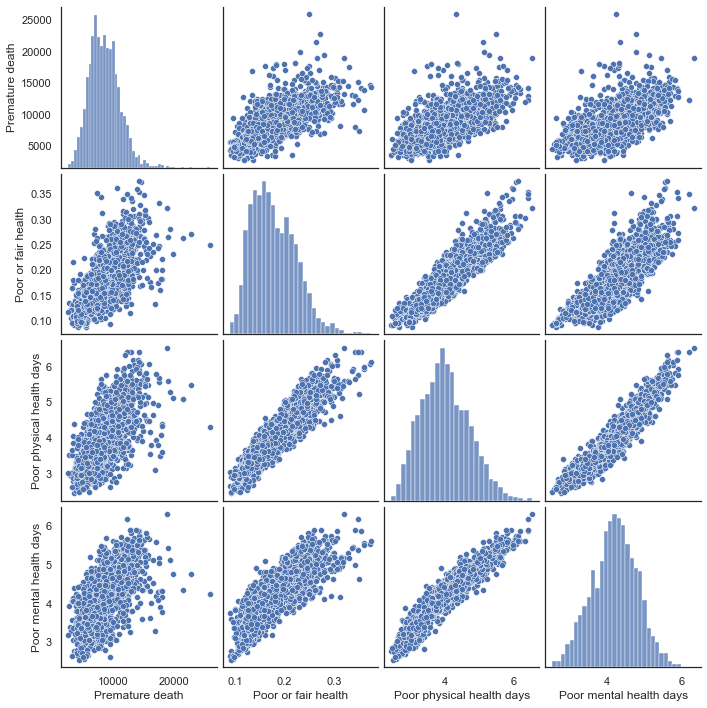

In [57]:
sns.pairplot(counties[health_vars])

Premature death has a weak positive correlation with the other three health outcome variables. Poor or fair health is strongly positively correlated with poor physical health days and poor mental health days. Poor physical health days is also strongly correlated with poor mental health days. Clearly, health outcome indicators do not exist in isolation, and counties that perform poorly one one health indicator is likely to perform poorly on other indicators as well. 

#### Clustering

To compute clusters, the variables first need to be scaled so that all features have the same range. We will only use numeric columns for clustering and predictive analyses. The county name will be set as the index of the dataframe and the state column will be dropped.

In [58]:
counties.set_index(counties['county'], inplace=True)
counties.drop(columns = ['state', 'county'], inplace=True)

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [60]:
scaler = StandardScaler()
transformed = scaler.fit_transform(counties)

In [61]:
cov = PCA(n_components = 10)
cov.fit(transformed)

PCA(n_components=10)

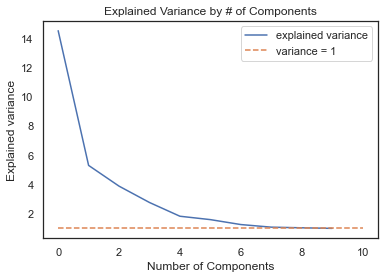

In [62]:
plt.plot(cov.explained_variance_, label = 'explained variance')
plt.plot([0, 10], [1, 1], '--', label = 'variance = 1')
plt.title('Explained Variance by # of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained variance')
plt.legend()

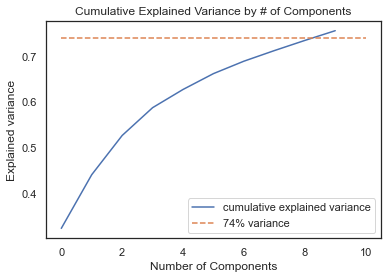

In [63]:
plt.plot(cov.explained_variance_ratio_.cumsum(), label = 'cumulative explained variance')
plt.plot([0, 10], [0.74, 0.74], '--', label = '74% variance')
plt.title('Cumulative Explained Variance by # of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained variance')
plt.legend()

The first plot shows that the first 8 components have eigenvalues of 1 or higher, indicating that each component captures some meaningful variation within the data. The second plot shows that 8 components together capture about 74% of the variation within the data. To maintain the variation in the data, 8 components will be used for this anaysis. 

In [64]:
pca = PCA(n_components = 8)
pca_ds = pca.fit_transform(transformed)

<AxesSubplot:>

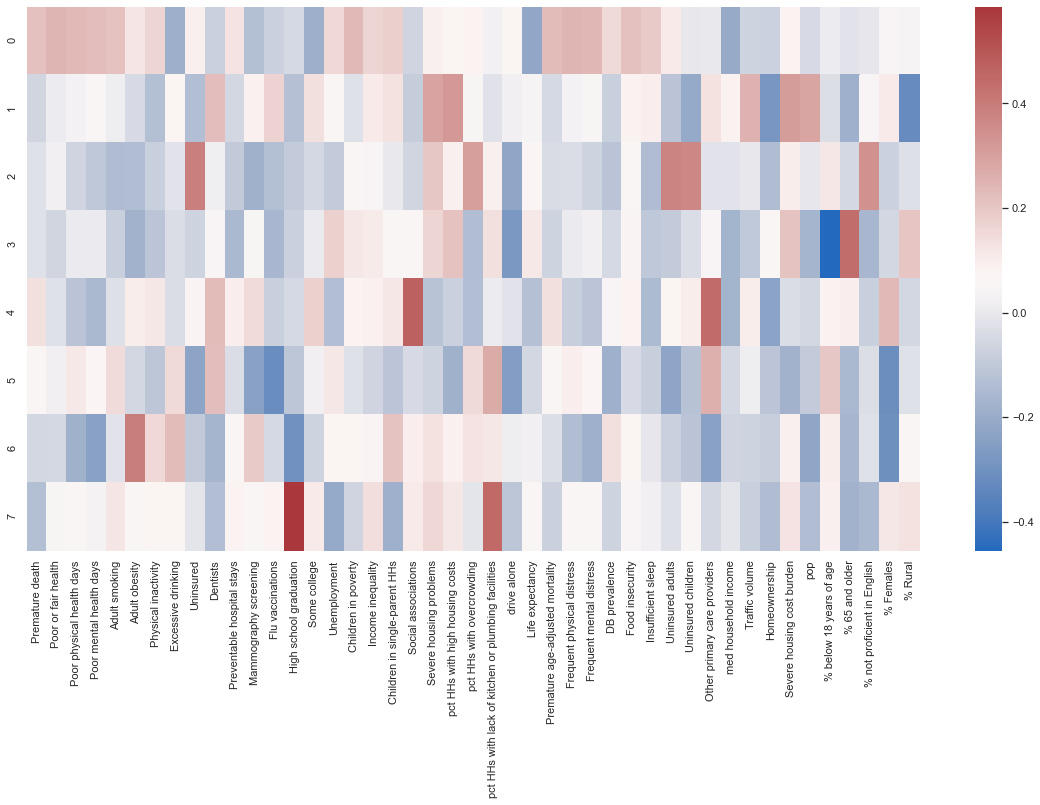

In [65]:
f, ax = plt.subplots(figsize=(20, 10))
loadings = pd.DataFrame(pca.components_, columns = counties.columns)
sns.heatmap(loadings, cmap = 'vlag')

The first component captures variation in health-related metrics such as premature death, poor physical health days, adult smoking, excessive drinking, life expectancy, and frequent physical distress. It also captures information about median household income.

The second component captures metrics such as physical inactivity, dentists, severe housing problems, pct HHs with high housing costs, homeownership, and % rural - societal and health-habit related metrics.

The third component captures accessibility to healthcare: uninsured, uninsured adults/children, mammography screening. It also captures other society/quality of life based matrics suc as pct HHs with overcrowding and % not proficient in english.

The fourth component is most highly influenced by population age, with the strongest factor loading from % below 18 years of age and % 65 and older. 

The next component is strongly influenced by social associatios and other PCPs. 

The sixth component captures additional healthcare and demographic data such as flu vaccinations and % female.

The seventh component is infuenced by adult obesity, and also by % female. It also captures some information about high school graduation rates. 

The final component is most heavily composed from high shcool graduation rates, followed by pct HHs with lack of plumbing and other societal based metrics such as childrein in single-parent HHs and unemployment. 

Next, use KMeans clustering to identify clusters.

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer 
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.26017127637982584
For n_clusters = 3 The average silhouette_score is : 0.16834976150694786
For n_clusters = 4 The average silhouette_score is : 0.17268353470337505
For n_clusters = 5 The average silhouette_score is : 0.17083928895578798
For n_clusters = 6 The average silhouette_score is : 0.168220951232832
For n_clusters = 7 The average silhouette_score is : 0.1612785905018305
For n_clusters = 8 The average silhouette_score is : 0.16139785717251456
For n_clusters = 9 The average silhouette_score is : 0.16242331158022089


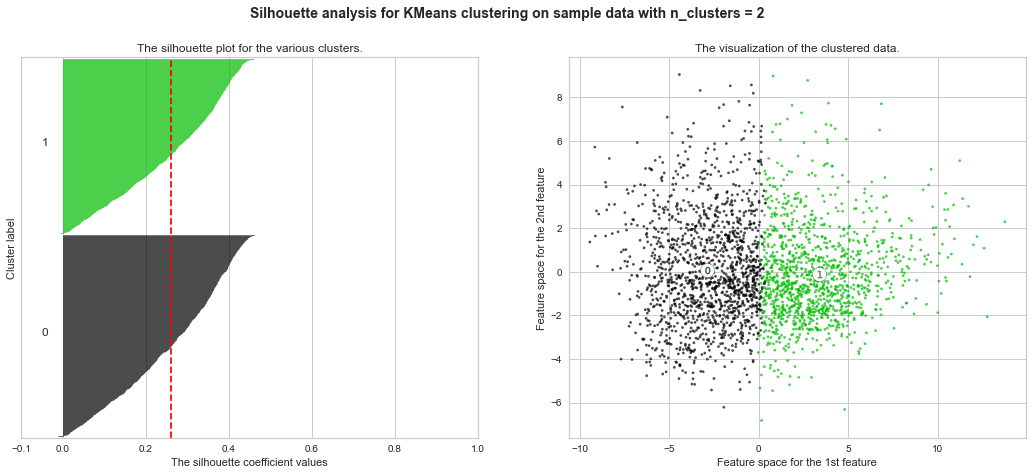

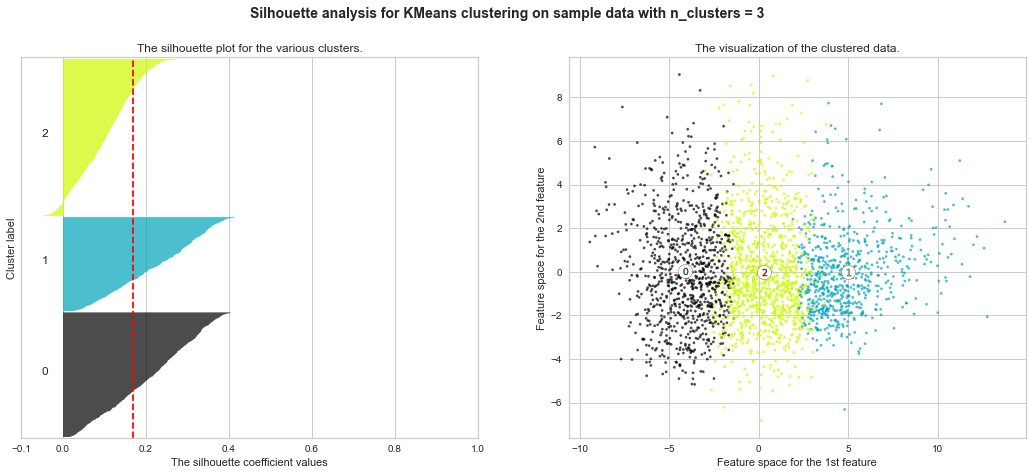

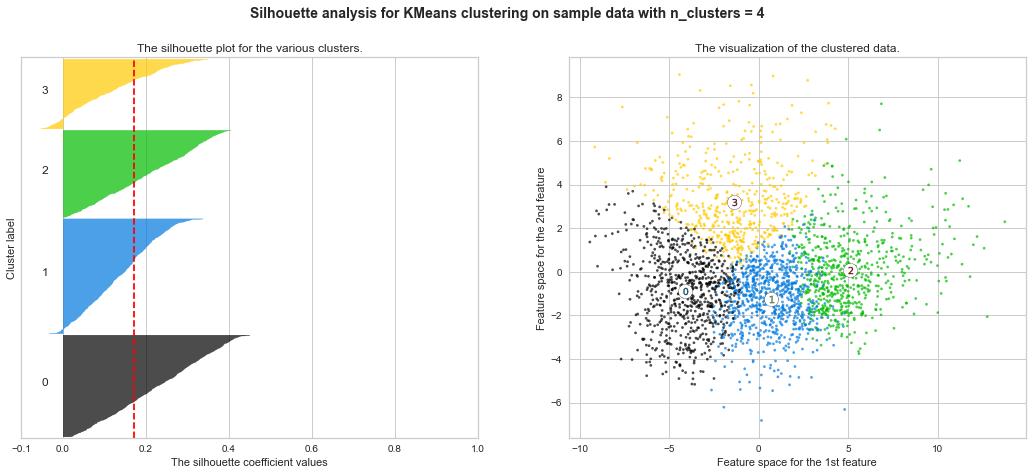

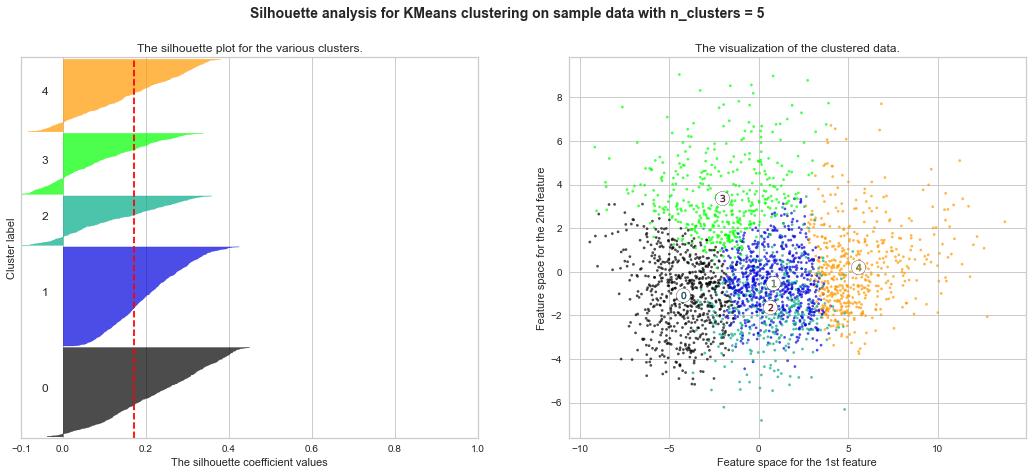

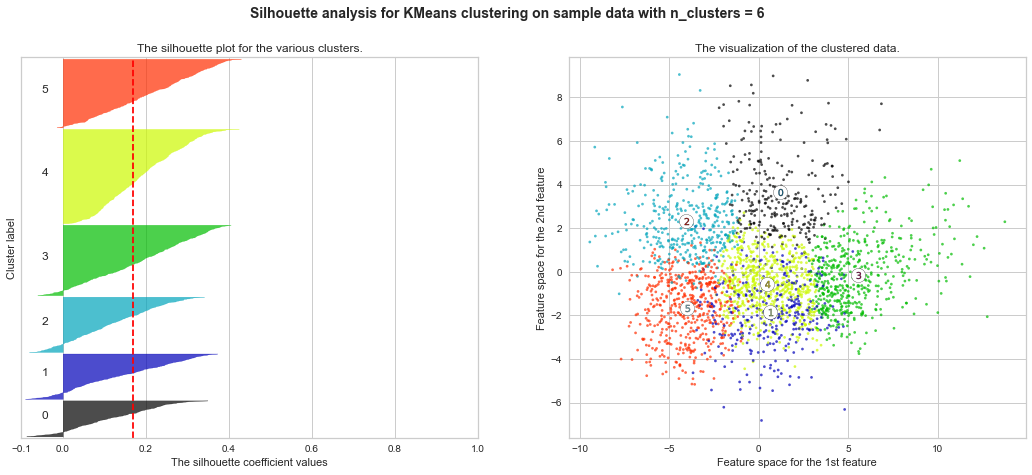

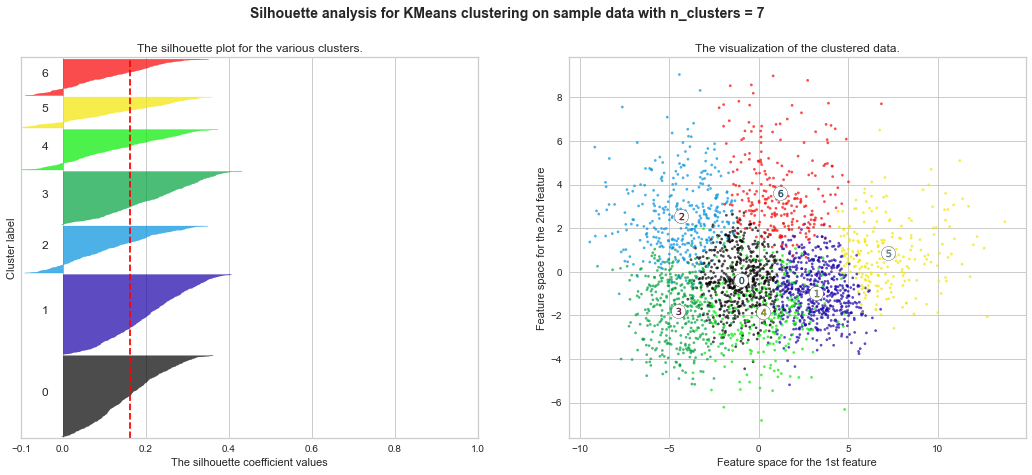

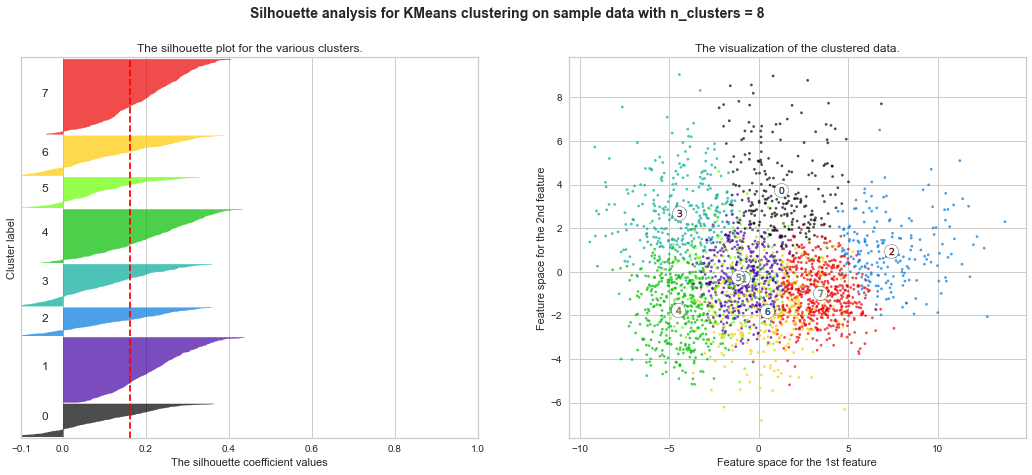

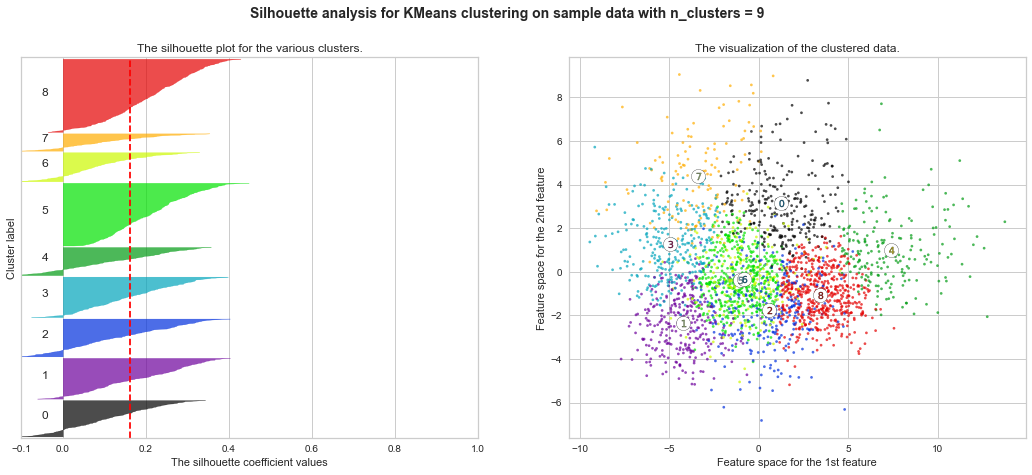

In [67]:
range_n_clusters = list(range(2, 10))

wcss = [] 

for n in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_ds) + (n + 1) * 10])
    clusters = KMeans(n_clusters=n, random_state=10)
    cluster_labels = clusters.fit_predict(pca_ds) 
    
    wcss.append(clusters.inertia_)
    
    silhouette_avg = silhouette_score(pca_ds, cluster_labels)
    print("For n_clusters =", n,
      "The average silhouette_score is :", silhouette_avg) 
    
    sample_silhouette_values = silhouette_samples(pca_ds, cluster_labels)
    
    y_lower = 10
    
    for i in range(n):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n)
    ax2.scatter(pca_ds[:, 0], pca_ds[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusters.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0.5, 1.0, 'Elbow Plot')

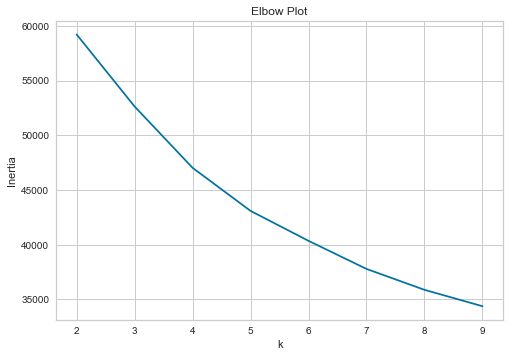

In [68]:
plt.plot(range_n_clusters, wcss)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot')

Based on the elbow plot, the inertia (within cluster sum of squares) continually decreases as the number of k increases, but the slope starts flattening slightly at around k = 5. Based on the silhouette plots above, k = 5 or 6 seems to be the optimal number of clusters. All clusters have well above-average silhouette scores, and the clusters are not too thin in area. Note that although the clusters seem to overlap in the visualization plot on features 1 and 2, the two visualized features are only two of 8 total components. Thus it is likely that the clusters are more clearly separable in higher dimensions. 

k = 5 will be used for this analysis. 

In [69]:
kmeansModel = KMeans(n_clusters = 5)
kmeansModel.fit(pca_ds)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = counties.index.values
cluster_map['cluster'] = kmeansModel.labels_

To analyze the clusters, first filter the data down to a more manageable size of variables. Since we are interested in health outcomes, lets examine those variables first.

In [70]:
# turn scaled dataset into dataframe for visualization
scaled = pd.DataFrame(transformed, columns = counties.columns, index = counties.index)

In [71]:
# assign clusters to the scaled data and get means of each feature 
clusters_data = pd.DataFrame(columns = scaled.columns)

for i in range(5):
    ct = cluster_map[cluster_map['cluster']==i]['data_index']
    subset = scaled[cols].loc[ct]
    means = subset.mean() 
    clusters_data.loc[i] = means

In [72]:
clusters_data.reset_index(inplace=True) 

In [73]:
clusters_data.rename(columns = {'index': 'cluster number'}, inplace = True)

In [74]:
clusters_data

cluster number  Premature death  Poor or fair health  \
0               0         0.038722             0.057836   
1               1         0.051994             0.043959   
2               2         0.282801             0.374761   
3               3        -0.189263            -0.117602   
4               4        -0.200308            -0.218442   

   Poor physical health days  Poor mental health days  Adult smoking  \
0                   0.003157                -0.007684      -0.071197   
1                   0.119605                 0.157921       0.156662   
2                   0.367322                 0.360678       0.375720   
3                  -0.056489                 0.002409      -0.088018   
4                  -0.206855                -0.201331      -0.129029   

   Adult obesity  Physical inactivity  Excessive drinking  Uninsured  ...  \
0      -0.011444             0.056313           -0.128009   0.333402  ...   
1       0.091335             0.087338           -0.088925  -0.178068  ...   
2       0.230989             0.292170           -0.295582  -0.038860  ...   
3      -0.131803            -0.239123            0.125849  -0.218561  ...   
4      -0.037583            -0.081113            0.138790  -0.202022  ...   

   med household income  Traffic volume  Homeownership  \
0             -0.057208       -0.080098       0.073268   
1             -0.054562       -0.046192       0.127512   
2             -0.268086       -0.055348      -0.031884   
3              0.202385        0.307616      -0.183925   
4              0.166506       -0.002071       0.182531   

   Severe housing cost burden       pop  % below 18 years of age  \
0                   -0.143597 -0.133885                 0.158936   
1                   -0.088324 -0.046618                -0.088707   
2                    0.084442 -0.073587                -0.009927   
3                    0.245407  0.371808                -0.120522   
4                   -0.202990 -0.084513                -0.003937   

   % 65 and older  % not proficient in English  % Females   % Rural  
0       -0.022033                     0.225095  -0.095594  0.118434  
1        0.024360                    -0.180993  -0.005290  0.081798  
2       -0.076344                    -0.173323   0.082089  0.095735  
3       -0.146558                     0.002990   0.057119 -0.284601  
4        0.054196                    -0.126503  -0.065239  0.092419  

[5 rows x 46 columns]

In [75]:
clusters_data.columns

Index(['cluster number', 'Premature death', 'Poor or fair health',
       'Poor physical health days', 'Poor mental health days', 'Adult smoking',
       'Adult obesity', 'Physical inactivity', 'Excessive drinking',
       'Uninsured', 'Dentists', 'Preventable hospital stays',
       'Mammography screening', 'Flu vaccinations', 'High school graduation',
       'Some college', 'Unemployment', 'Children in poverty',
       'Income inequality', 'Children in single-parent HHs',
       'Social associations', 'Severe housing problems',
       'pct HHs with high housing costs', 'pct HHs with overcrowding',
       'pct HHs with lack of kitchen or plumbing facilities', 'drive alone',
       'Life expectancy', 'Premature age-adjusted mortality',
       'Frequent physical distress', 'Frequent mental distress',
       'DB prevalence', 'Food insecurity', 'Insufficient sleep',
       'Uninsured adults', 'Uninsured children',
       'Other primary care providers', 'med household income',
       'Traf

As there are over 40 variables to examine, they will generally be grouped by theme before plotting and analysis.

In [76]:
health_cols = ['cluster number', 'Premature death', 'Adult obesity', 'Uninsured', 'Poor mental health days', 'Preventable hospital stays', 'Mammography screening', 'Flu vaccinations']

In [77]:
habit_cols = [ 'cluster number', 'Adult smoking', 'Physical inactivity', 'Excessive drinking',  'drive alone']

In [78]:
societal_cols = ['cluster number', 'Homeownership', 'pct HHs with high housing costs', 'Some college', 'High school graduation', 'med household income','Social associations']

In [79]:
econ_cols = ['cluster number','Severe housing cost burden', 'Children in poverty', 'Food insecurity', 'Unemployment', 'pct HHs with overcrowding']

In [80]:
demographic_cols = ['cluster number', 'pop', '% below 18 years of age', '% 65 and older', '% not proficient in English', '% Females', '% Rural']

Text(0.5, 1.0, 'Health related variables')

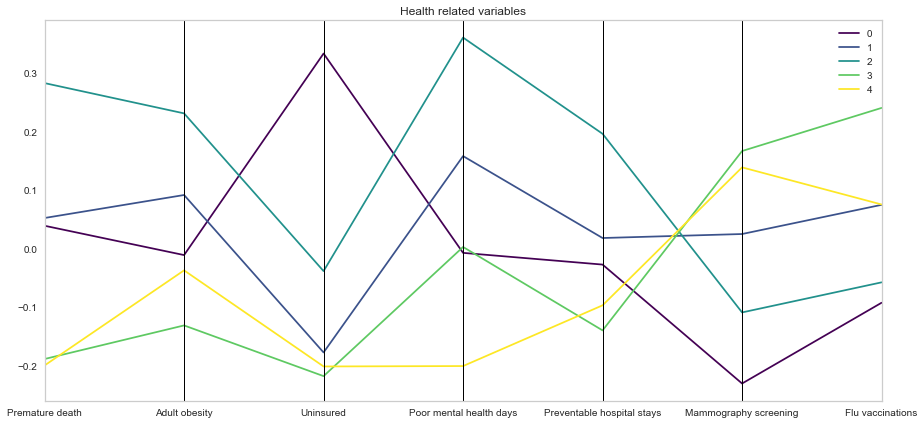

In [81]:
f = plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(clusters_data[health_cols], 'cluster number', colormap = 'viridis')
plt.title('Health related variables')

The clusters are clearly differentiated by health outcomes. Cluster 1 tends to have poor health, with high rates of premature death, poor mental health days, high adult obesity, low rates of mammography screening, and low flu vaccination rates. Clusters 2 and 3 have similar rates of premature death but are highly differentiated by the uninsured metric. They also differ on flu vaccination rates and mammography screening rates, with cluster 3 (with lower uninsured rates) having higher rates of preventative services. Interestingly, this cluster also has high poor mental health dates and preventable hospital stays compared to cluster 2. Clusters 0 and 4 have the lowest premature death rates (healthy counties). They have low adult obseity rates, low uninsured rates, as well as how preventable hospital stays, and high preventative health services. The two clusters are most differentiated in the rate of poor mental health days (cluster 0 having much higher rates than cluster 4).

Text(0.5, 1.0, 'Habit related variables')

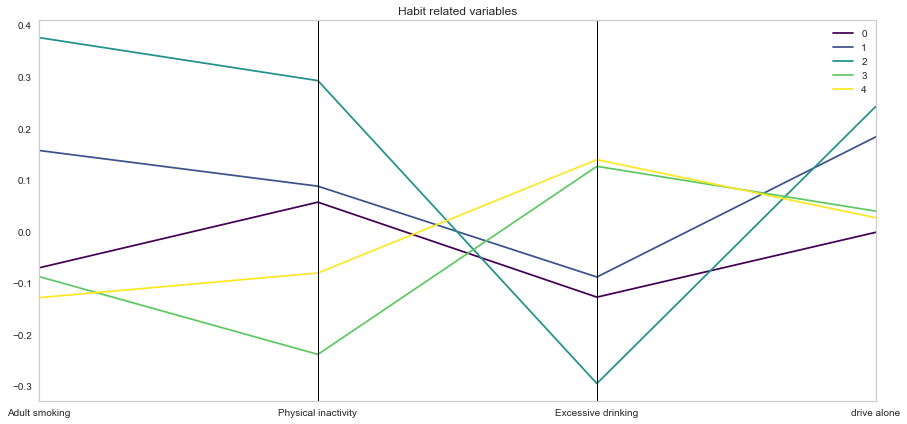

In [82]:
f = plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(clusters_data[habit_cols], 'cluster number', colormap = 'viridis')
plt.title('Habit related variables')

The clusters are also differentiated by habits. Again, cluster 1 stands out as the unhealthy cluster, with high adult smoking and physical inactiity rates. Interesting, it has the lowest excessive drinking rates, although this metric generally tends to be misreported by individuals. Clusters 2 and 3 are in the middle in terms of healthy habits, while clusters 0 and 4 are again the healthyiest, with lower adult smoking and physical inactivity rates. They also show higher excessive drinking rates, but again, this metric is somewhat unreliable. 

Text(0.5, 1.0, 'Society related variables')

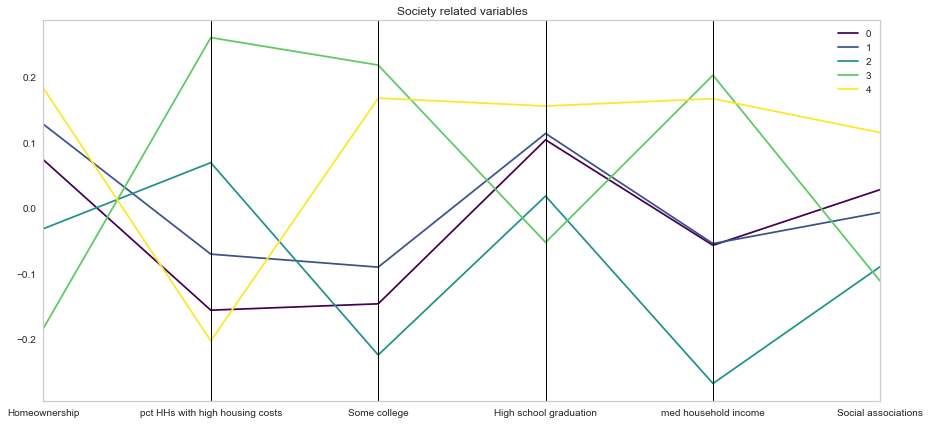

In [83]:
f = plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(clusters_data[societal_cols], 'cluster number', colormap = 'viridis')
plt.title('Society related variables')

By general societal features, the clusters keep with previous observations that clusters 0 and 4 generally have more positive societal outcomes, including higher college education rates, lower unemployment rates, and higher median household income. Cluster 0 is differentiated from cluster 4 here by having significantly lower high school graduation rates and lower social association scores. Most interestingly, it seems to have the lowest rates of homeownership, despite having high median household income. This is perhaps driven by locations like NY and SF where homeownership rates are low because of a huge surplus of demand and prevalence of renting instead of owning. This is confirmed by the rate of pct HHs with high housing costs in this cluster compared to other clusters. 

Clusters 2 and three perform similarly with rather average rates on these metrics, and differ slightly on pct HHs with high housing costs and college education rates. Cluster 1 again stands out as performing worse on these indicators than other clusters, having lower college education rates, significantly lower median household income, and generally low social associations scores. 

Text(0.5, 1.0, 'Economic and financial related variables')

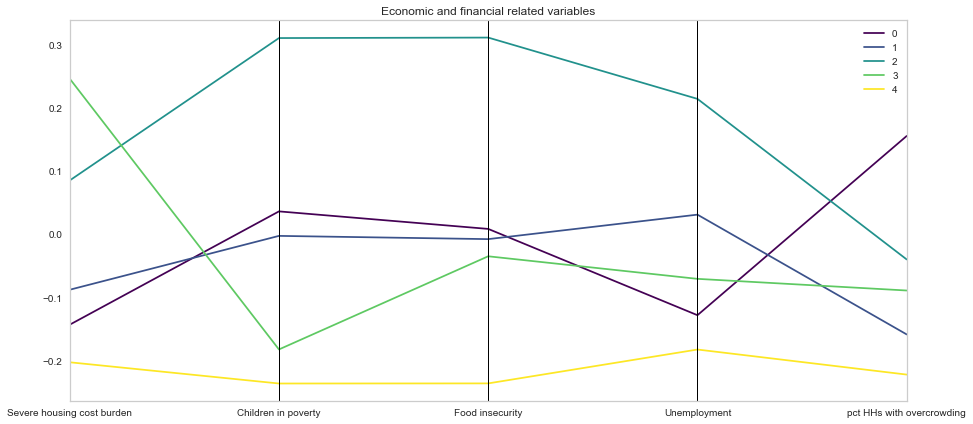

In [84]:
f = plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(clusters_data[econ_cols], 'cluster number', colormap = 'viridis')
plt.title('Economic and financial related variables')

In this last group of variables, similar trends emerge where clusters 0 and 4 seem to represent more well-off counties with fewer children in poverty, lower rates of food insecurity, generally lower unemployment rates and overcrowding rates. However, the two clusters differ significantly in the housing cost burden, which aligns with the housing-related metrics in the previous graph. Clusters 2 and 3 are mostly differentiated by unemployment and overcrowding rates. Lastly, cluster 1 stands out for performing poorly on all metrics here.

Text(0.5, 1.0, 'Demographic related variables')

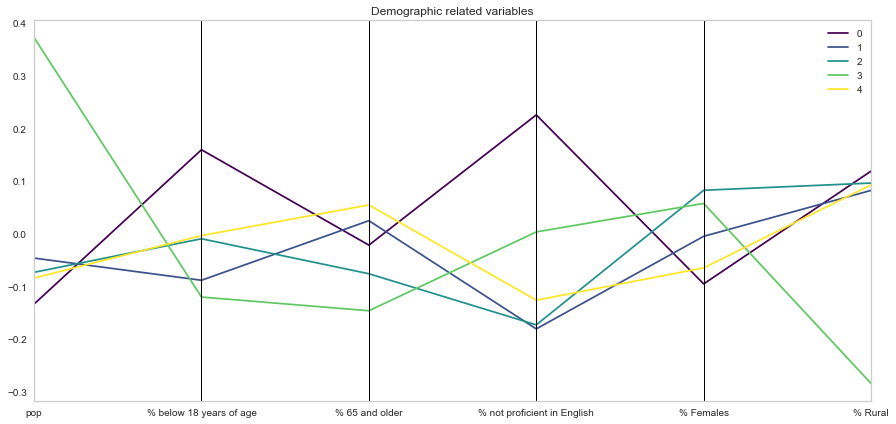

In [85]:
f = plt.figure(figsize=(15, 7))
pd.plotting.parallel_coordinates(clusters_data[demographic_cols], 'cluster number', colormap = 'viridis')
plt.title('Demographic related variables')

In alignment with previous observations about homeownership rates and housing costs in previous plots, cluster 4 here is shown as having the highest population rates and lowest % Rural rates. Age-wise they are low in % below 18 and % above 65, indicating metropolises with a higher proportion of working age individuals. They also have generally higher % female rates. Cluster 2 stands out for having the highest rates of % not proficient in English and generally younger populations. Cluster 1 has lower % not proficient in English rates, suggesting that these counties are rural locations with higher poverty rates and lower racial diversity, which conforms to certain regions of the United States. Cluster 4 has the highest rates of % 65 and older individuals, which may represent affluent counties with a higher retirement-aged population. 

In general, the cluster analysis reveals noteworthy characteristics of U.S. counties in terms of health outcomes and habits, social/economic situations, as well as overall demographics information. 

### Predictive Modeling

Next, we will develop two predictive models to predict premature death rates using other metrics in this dataset. First, re-examine the distribution of the premature death dependent variable. In predictive modeling, outliers may reduce model accuracy, so in this case we may want to remove extreme outliers.

<AxesSubplot:xlabel='Premature death'>

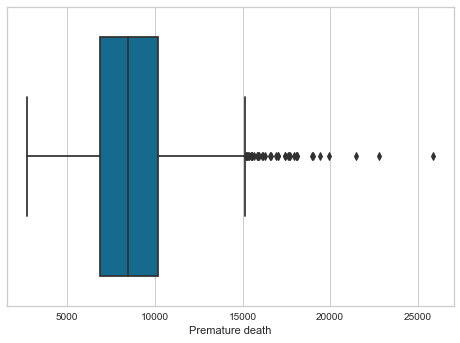

In [86]:
sns.boxplot(x = 'Premature death', data = counties)

There is one very extreme outlier above 25,000 and two outliers above 20,000. These 3 observations will be removed from the modelling process.

In [87]:
counties = counties[counties['Premature death']<20000]

The goal of this modelling is to identify contributors to premature death and develop policy recommendations for counties. As such, PCA will not be used for feature processing as it reduces interpretability of the models. This means that multicollinearity will be an issue and will need to be resolved. VIF will be used to remove features that are highly correlated with other features. 

In [88]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

scaled_X = scaled.loc[:, scaled.columns != 'Premature death'].copy()

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]

In [89]:
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature          VIF
7                          Uninsured  1507.154369
31                  Uninsured adults  1109.124219
26        Frequent physical distress   158.640085
1          Poor physical health days   112.336050
27          Frequent mental distress   108.936430
19           Severe housing problems    86.530123
20   pct HHs with high housing costs    73.042301
32                Uninsured children    65.433700
2            Poor mental health days    60.976925
0                Poor or fair health    17.760737
25  Premature age-adjusted mortality    13.465717
24                   Life expectancy    11.272281
21         pct HHs with overcrowding    10.888141

Columns with high VIFs will be removed sequentially to reduce multicollinearity.

In [90]:
to_drop = []
to_drop.append('Uninsured')

scaled_X.drop(columns = ['Uninsured'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature         VIF
25        Frequent physical distress  158.527209
1          Poor physical health days  112.318994
26          Frequent mental distress  108.580558
18           Severe housing problems   86.487340
19   pct HHs with high housing costs   72.963830
2            Poor mental health days   60.916560
0                Poor or fair health   17.524594
24  Premature age-adjusted mortality   13.459837
23                   Life expectancy   11.218779
20         pct HHs with overcrowding   10.887786

In [91]:
to_drop.append('Frequent physical distress')

scaled_X.drop(columns = ['Frequent physical distress'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature        VIF
18           Severe housing problems  86.332474
19   pct HHs with high housing costs  72.825301
25          Frequent mental distress  69.669443
2            Poor mental health days  40.410335
1          Poor physical health days  26.172537
0                Poor or fair health  15.777591
24  Premature age-adjusted mortality  13.446132
23                   Life expectancy  11.162009
20         pct HHs with overcrowding  10.876370

In [92]:
to_drop.append('Severe housing problems')

scaled_X.drop(columns = ['Severe housing problems'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature        VIF
24          Frequent mental distress  69.513090
2            Poor mental health days  40.269675
1          Poor physical health days  26.160007
0                Poor or fair health  15.769605
23  Premature age-adjusted mortality  13.445746
22                   Life expectancy  11.159301

In [93]:
to_drop.append('Frequent mental distress')

scaled_X.drop(columns = ['Frequent mental distress'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature        VIF
1          Poor physical health days  24.185556
0                Poor or fair health  15.769309
2            Poor mental health days  13.582606
23  Premature age-adjusted mortality  13.441286
22                   Life expectancy  11.090585

In [94]:
to_drop.append('Poor physical health days')

scaled_X.drop(columns = ['Poor physical health days'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature        VIF
22  Premature age-adjusted mortality  13.435132
0                Poor or fair health  11.928126
21                   Life expectancy  11.090456

In [95]:
to_drop.append('Premature age-adjusted mortality')

scaled_X.drop(columns = ['Premature age-adjusted mortality'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

feature        VIF
0  Poor or fair health  11.865585

In [96]:
to_drop.append('Poor or fair health')

scaled_X.drop(columns = ['Poor or fair health'], inplace=True) 

vif_data = pd.DataFrame()
vif_data['feature'] = scaled_X.columns
vif_data['VIF'] = [variance_inflation_factor(scaled_X.values, i) for i in range(len(scaled_X.columns))]
vif_data[vif_data['VIF']>=10].sort_values(by = 'VIF', ascending=False)

Empty DataFrame
Columns: [feature, VIF]
Index: []

Lastly, life expectancy will be dropped as it highly correlated with the outcome variable and is also a direct factor in calculating premature deaths. This will be removed because we are interested in causal factors/correlated factors that could be addressed by policy action. We know that life expectancy is highly correlated with the outcome, but there is no way to directly improve premature death rates by altering life expectancy. Thus, to avoid leakage in the model, this feature will also be removed.

In [97]:
to_drop.append('Life expectancy')
to_drop

['Uninsured',
 'Frequent physical distress',
 'Severe housing problems',
 'Frequent mental distress',
 'Poor physical health days',
 'Premature age-adjusted mortality',
 'Poor or fair health',
 'Life expectancy']

We now have the list of features to drop to reduce multicollinearity in the dataset.

In [98]:
counties.drop(columns = to_drop, inplace = True)

To avoid leakage in the modelling process, the data will be split into train-test datasets first prior to applying transformation techniques for scaling (in other words, scaling will be trained on the train dataset only, and then used to transform the test dataset). This ensures integrity in the modelling process and treats testing data as a wholly unseen dataset.

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X = counties.loc[:, counties.columns != 'Premature death']
y = counties['Premature death']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [102]:
# apply scaling
scaler = StandardScaler()
# fit on training dataset only 
scaler.fit(X_train) 
# transform training dataset
X_train = scaler.transform(X_train)

# transform testing dataset 
X_test = scaler.transform(X_test) 

First, a basic linear model will be fitted for baseline evaluation. 

In [103]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [104]:
params = {'alpha': [20, 18, 16, 14, 12, 10, 5, 1, 0.1, 0.01]}
ridge = Ridge()
lasso = Lasso()
e_net = ElasticNet()

for model in [ridge, lasso, e_net]:
    cv = GridSearchCV(model, params, cv = 5, scoring = ['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
    cv.fit(X_train, y_train)
    
    RMSE = (-cv.best_score_.mean())**(1/2)
    print('model: ', model) 
    print('cross-validated mean RMSE: {:.3f}'.format(RMSE))
    mean_R2 = cv.cv_results_['mean_test_r2'].mean()
    print('cross-validated mean R2: {:.3f}'.format(mean_R2))
    print('best model parameter: ', cv.best_estimator_, '\n')

model:  Ridge()
cross-validated mean RMSE: 1444.995
cross-validated mean R2: 0.660
best model parameter:  Ridge(alpha=20) 

model:  Lasso()
cross-validated mean RMSE: 1442.394
cross-validated mean R2: 0.661
best model parameter:  Lasso(alpha=14) 

model:  ElasticNet()
cross-validated mean RMSE: 1443.605
cross-validated mean R2: 0.555
best model parameter:  ElasticNet(alpha=0.1) 



The best linear model is Lasso regression with alpha = 14. This model has decent fit, explaining 66% of the variance in the dataset and having the lowest RMSE of 1525. 

In [105]:
lm = Lasso(alpha = 14)
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Test R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('Test RMSE: {:.3f}'.format((mean_squared_error(y_test, y_pred))**(1/2)))

Test R2: 0.682
Test RMSE: 1353.965


The Lasso model performs moderately well on the test dataset, achieving an R2 score of 0.68 and a lower RMSE of 1354 compared to the cross-validated results. This improvement may be attributed to the increased dataset size for training compared to during the cross-validation process. The plot below shows the model compared to the identity (perfect fit) line.

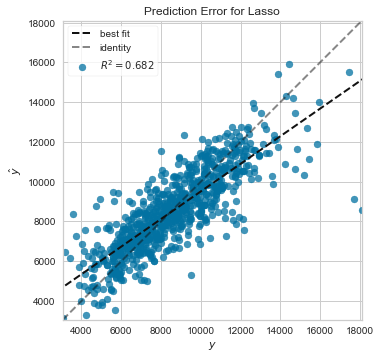

In [106]:
from yellowbrick.regressor import prediction_error 

visualizer = prediction_error(lm, X_train, y_train, X_test, y_test)

In [107]:
importance = np.abs(lm.coef_)

features = X.columns

feat_importance = pd.DataFrame([features, importance]).transpose()
feat_importance.rename(columns = {0: 'feature', 1: 'coefficient'}, inplace=True)
feat_importance.sort_values(by = 'coefficient', ascending = False)

feature coefficient
1                                       Adult smoking     623.035
12                                Children in poverty     470.759
7                               Mammography screening     338.735
4                                  Excessive drinking     232.609
32                                     % 65 and older     226.645
31                            % below 18 years of age     216.762
33                        % not proficient in English     201.821
26                               med household income     188.658
19                                        drive alone     171.813
14                      Children in single-parent HHs     166.684
25                       Other primary care providers     165.748
20                                      DB prevalence     159.459
29                         Severe housing cost burden     128.127
34                                          % Females     118.564
17                          pct HHs with overcrowding     117.947
9                              High school graduation     111.463
13                                  Income inequality     93.3866
11                                       Unemployment     69.2418
24                                 Uninsured children     66.4583
5                                            Dentists     47.0827
3                                 Physical inactivity     44.7503
23                                   Uninsured adults     42.7301
22                                 Insufficient sleep      40.326
0                             Poor mental health days     32.6349
28                                      Homeownership     27.5051
10                                       Some college     18.4408
18  pct HHs with lack of kitchen or plumbing facil...     13.3892
2                                       Adult obesity     10.4859
15                                Social associations     1.67669
27                                     Traffic volume           0
21                                    Food insecurity           0
16                    pct HHs with high housing costs           0
30                                                pop           0
8                                    Flu vaccinations           0
6                          Preventable hospital stays           0
35                                            % Rural           0

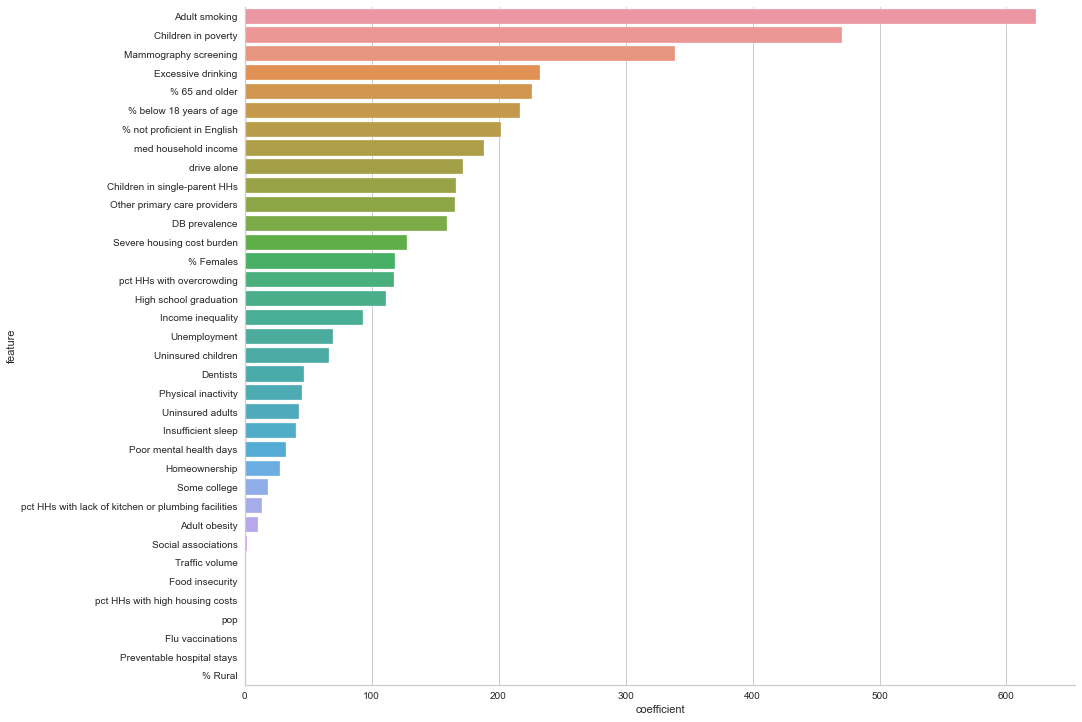

In [108]:
sns.catplot(y='feature', x = 'coefficient', data =feat_importance.sort_values(by='coefficient', ascending=False), kind = 'bar', height = 10, aspect = 1.5)

As shown above, the 5 most important features in predicting premature death are: adult smoking, children in poverty, mammography screening, age (% above 65 and % below 18), as well as excessive drinking. Severe housing costs, and median household income follow as the next two most important features.

Next, try a tree based model. Tree based models do not assume a linear relationship between variables, and may thus achieve better model performance.

In [109]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
rf = RandomForestRegressor(random_state = 42)

params = {'n_estimators': [100, 150, 300],
             'max_depth': [10, 25, 50, 60]}

cv = GridSearchCV(rf, params, cv = 5, scoring = ['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 25, 50, 60],
                         'n_estimators': [100, 150, 300]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [111]:
RMSE = (-cv.best_score_.mean())**(1/2)
print('model: Random Forest') 
print('cross-validated mean RMSE: {:.3f}'.format(RMSE))
mean_R2 = cv.cv_results_['mean_test_r2'].mean()
print('cross-validated mean R2: {:.3f}'.format(mean_R2))
print('best model parameter: ', cv.best_estimator_, '\n')

model: Random Forest
cross-validated mean RMSE: 1470.615
cross-validated mean R2: 0.649
best model parameter:  RandomForestRegressor(max_depth=50, n_estimators=150, random_state=42) 



The best Random Forest model achieved slightly worse performace than the Lasso regression, with the best parameters being max_depth = 60 and n_estimators = 150. The R2 is around 65% and RMSE is slightly higher than the Lasso CV value, at 1470.

In [112]:
rf = RandomForestRegressor(n_estimators = 150, max_depth = 60, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Test R2: {:.3f}'.format(r2_score(y_test, y_pred)))
print('Test RMSE: {:.3f}'.format((mean_squared_error(y_test, y_pred))**(1/2)))

Test R2: 0.690
Test RMSE: 1335.869


 When tested on the test data, the RF regressor performed about the same as the Lasso regression, achieving 69% R2 and an RMSE of 1335. 

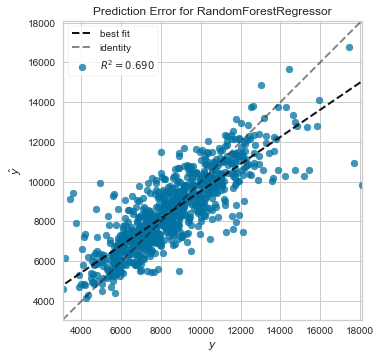

In [113]:
visualizer = prediction_error(rf, X_train, y_train, X_test, y_test)

In [114]:
importance = np.abs(rf.feature_importances_)

features = X.columns

feat_importance = pd.DataFrame([features, importance]).transpose()
feat_importance.rename(columns = {0: 'feature', 1: 'importance'}, inplace=True)
feat_importance.sort_values(by = 'importance', ascending = False)

feature  importance
12                                Children in poverty    0.447512
1                                       Adult smoking   0.0991356
26                               med household income   0.0568955
4                                  Excessive drinking   0.0477886
0                             Poor mental health days   0.0202511
3                                 Physical inactivity   0.0174468
31                            % below 18 years of age   0.0152588
10                                       Some college   0.0152432
30                                                pop   0.0150132
19                                        drive alone   0.0143593
29                         Severe housing cost burden    0.013611
20                                      DB prevalence   0.0135036
21                                    Food insecurity   0.0121196
7                               Mammography screening   0.0119449
14                      Children in single-parent HHs   0.0118976
34                                          % Females   0.0117947
15                                Social associations   0.0115865
33                        % not proficient in English   0.0114213
22                                 Insufficient sleep   0.0110929
6                          Preventable hospital stays   0.0110003
13                                  Income inequality   0.0103085
17                          pct HHs with overcrowding   0.0102099
25                       Other primary care providers  0.00938775
11                                       Unemployment  0.00921134
2                                       Adult obesity  0.00913581
27                                     Traffic volume  0.00897441
9                              High school graduation  0.00858982
16                    pct HHs with high housing costs  0.00843698
5                                            Dentists  0.00814662
32                                     % 65 and older  0.00761814
18  pct HHs with lack of kitchen or plumbing facil...  0.00726859
35                                            % Rural  0.00725262
23                                   Uninsured adults  0.00716198
24                                 Uninsured children  0.00715397
8                                    Flu vaccinations  0.00710473
28                                      Homeownership  0.00516266

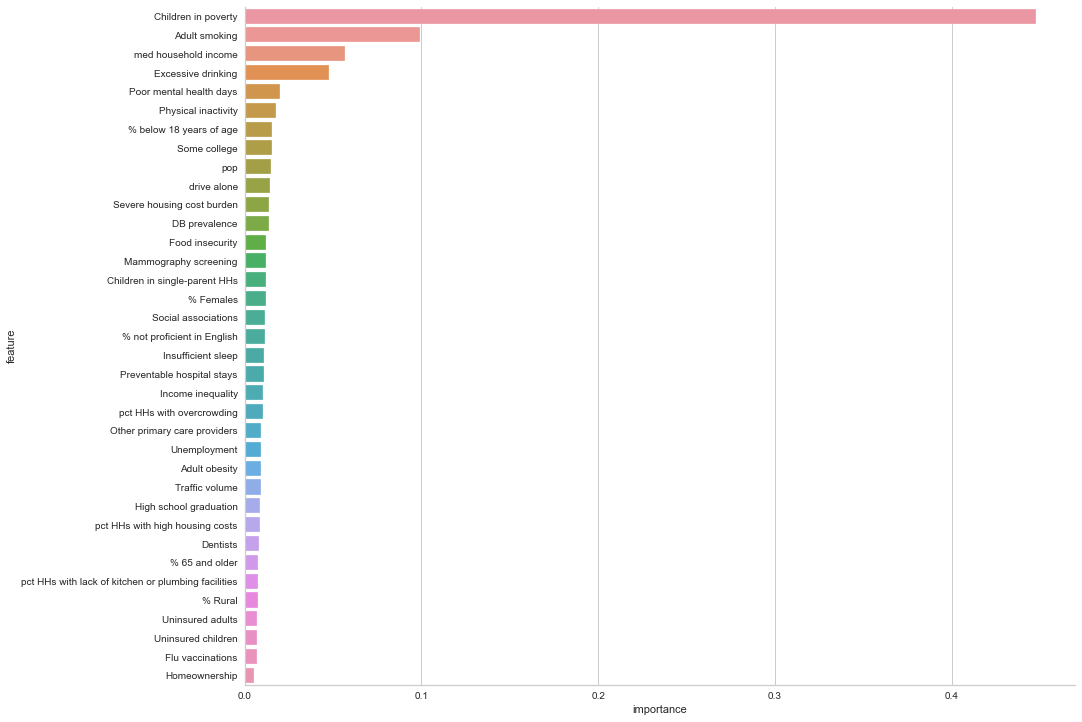

In [115]:
sns.catplot(y='feature', x = 'importance', data =feat_importance.sort_values(by='importance', ascending=False), kind = 'bar', height = 10, aspect = 1.5)

based on the Random Forest model, children in poverty is by far the most important feature in predicting premature deaths. This is followed by adult smoking, median household income, excessive drinking, poor mental health days, and physical inactivity. These are followed by Physical inactivity, % below 18, and severe housing burden. Smoking, children in poverty, and excessive drinking were identified by both models as being in the top 5 most important predictors of premature deaths.

#### Allegheny County

In [116]:
data[data['county']=='Allegheny County'][['Adult smoking', 'Children in poverty', 'Excessive drinking', 'med household income', 'Poor mental health days']].transpose()

2285
Adult smoking                0.169910
Children in poverty          0.150000
Excessive drinking           0.220194
med household income     59881.000000
Poor mental health days      3.835273

In [117]:
data[['Adult smoking', 'Children in poverty', 'Excessive drinking', 'med household income', 'Poor mental health days']].describe().transpose()

count          mean           std           min  \
Adult smoking            3194.0      0.174666      0.036066      0.059087   
Children in poverty      3193.0      0.210454      0.088622      0.025000   
Excessive drinking       3194.0      0.175300      0.031486      0.078096   
med household income     3193.0  52944.895709  13878.755803  25385.000000   
Poor mental health days  3194.0      4.166482      0.602004      2.532818   

                                  25%           50%           75%  \
Adult smoking                0.149431      0.169574      0.197149   
Children in poverty          0.145000      0.201000      0.262000   
Excessive drinking           0.153118      0.175788      0.196769   
med household income     43783.000000  50748.000000  59020.000000   
Poor mental health days      3.747219      4.171248      4.574442   

                                   max  
Adult smoking                 0.414913  
Children in poverty           0.683000  
Excessive drinking            0.286237  
med household income     140382.000000  
Poor mental health days       6.313753

In Allegheny county, there is below average proportion of children in poverty and poor mental health days, and slightly above average median household income compared to other counties in the U.S.. However, the county has higher rates of adult smoking and excessive drinking, two factors that are highly important in predicting premature deaths. Public health efforts should focus on education with regard to the harms of smoking and excessive drinking, as well as other policy mechanisms to curb such unhealthy behaviors. 